## Introduction to PyMC3

### Prerequisite - Course 2

### Attribution

It is important to acknowledge the authors who have put together fantastic resources that have allowed me to make this notebook possible. 


1. *The majority of the the examples here are taken from the book 'Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ', Second Edition by Osvaldo Martin*

2. [PyMC3 website](docs.pymc.io)

3. Bayesian Methods for Hackers by Davidson-Pilon Cameron

4. Doing Bayesian Data Analysis by John Kruschke

### Overview of Probabilistic Programming 

An overview of probabilistic frameworks is given in this [post](https://eigenfoo.xyz/prob-prog-frameworks/)  by George Ho, one of the developers of PyMC3. He outlines the components needed for a probabilistic framework in this figure 

<img src="https://eigenfoo.xyz/assets/images/prob-prog-flowchart.png" width="400">

<br></br>
<center>Figure from George Ho's post 'Anatomy of a Probabilistic Programming Framework"</center>



### What is PyMC3?

PyMC3 is a probabilistic programming framework for performing Bayesian modeling and visualization. It uses Theano as a backend. It has algorithms to perform Monte Carlo simulation as well as Variational Inference. It also has a diagnostic visualization tool called ArViz.

It can be used to infer values of parameters of models that we are unsure about by utilizing the observed data. A good example is given here [https://docs.pymc.io/notebooks/ODE_API_introduction.html](https://docs.pymc.io/notebooks/ODE_API_introduction.html). 

$$ \dfrac{dy}{dt} = m g - \gamma y$$
We are trying to estimate the parameters of air resistance (\\(\gamma\\)) from the Ordinary Differential Equation (ODE) of freefall. We have an understanding of the physics behind freefall as represented by the ODE and we have observed/measured some of the variables such as mass (m), position (y) and velocity (\\(\dfrac{dy}{dt}\\)) but we don't know what the parameter of air resistance is here. We can use PyMC3 to perform inference and give us a distribution of potential values of air resistance. A key point to note here is that the more information we have regarding other variables, the more certainty we have in our desired variable (air resistance). Suppose we are unsure about the gravitational constant (g) used in the ODE (implemented by specifying a prior distribution as opposed to a constant value of 9.8), we get more uncertainty in the air resistance variable as well.


### General Structure of PyMC3

It consists of phenomena represented by equations made up of random variables and deterministic variables. The random variables can be divided into observed variables and unobserved variables. The observed variables are those for which we have data and the unobserved variables are those for which we have to specify a prior distribution.

#### Observed Variables

```
with pm.Model():
    obs = pm.Normal('x', mu=0, sd=1, observed=np.random.randn(100))
```

#### Unobserved Variables

```
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
```

We will look at an example of Linear Regression to illustrate the fundamental features of PyMC3.

### An example with Linear Regression

The example below illustrates linear regression with a single output variable and two input variables.

$$ y = \alpha + \beta_1 x_1 +  \beta_2 x_2 + \sigma_{error} $$

In [3]:
import pymc3
pymc3.__version__

'3.10.0'

#### Generate the Data

In [4]:
%matplotlib inline
import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import graphviz
import os

os.environ['OMP_NUM_THREADS'] = '4'

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [5]:
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
from pymc3 import find_MAP

#### Model Setup in PyMC3

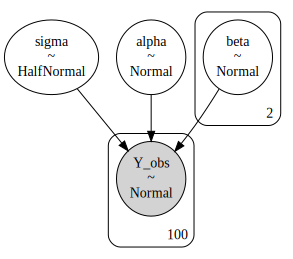

In [6]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=5)
    beta = Normal('beta', mu=0, sd=5, shape=2)
    sigma = HalfNormal('sigma', sd=4)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2 
    
    # Deterministic variable, to have PyMC3 store mu as a value in the trace use
    # mu = pm.Deterministic('mu', alpha + beta[0]*X1 + beta[1]*X2)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

pm.model_to_graphviz(basic_model)

##### Plate Notation

A way to graphically represent variables and their interactions in a probabilistic framework.

[Wikipedia Plate Notation](https://en.wikipedia.org/wiki/Plate_notation)

#### MAP Estimate 

PyMC3 computes the MAP estimate using numerical optimization, by default using the BFGS algorithm. These provide a point estimate which may not be accurate if the mode does not appropriately represent the distribution.

In [55]:
map_estimate = find_MAP(model=basic_model, maxeval=10000)
map_estimate

logp = -164.27, ||grad|| = 3.5988: 100%|██████████| 20/20 [00:00<00:00, 3204.69it/s]   


{'alpha': array(1.0154193),
 'beta': array([1.46379432, 0.29275886]),
 'sigma_log__': array(0.12023688),
 'sigma': array(1.12776396)}

#### Inference in PyMC3

In [32]:
from pymc3 import NUTS, sample
from scipy import optimize

In [45]:
with basic_model:
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler - not really a good practice
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

Optimization terminated successfully.
         Current function value: 163.261934
         Iterations: 5
         Function evaluations: 230


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.


You can also pass a parameter to step that indicates the type of sampling algorithm to use such as

* Metropolis
* Slice sampling
* NUTS

PyMC3 can automatically determine the most appropriate algorithm to use here, so it is best to use the default option.

#### Distribution Information through Traceplots

In [58]:
trace['alpha']

array([1.17257076, 0.66991082, 1.26713518, ..., 1.3967013 , 1.2705309 ,
       1.10360491])

In [59]:
from pymc3 import traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc311abd580>,
      dtype=object)

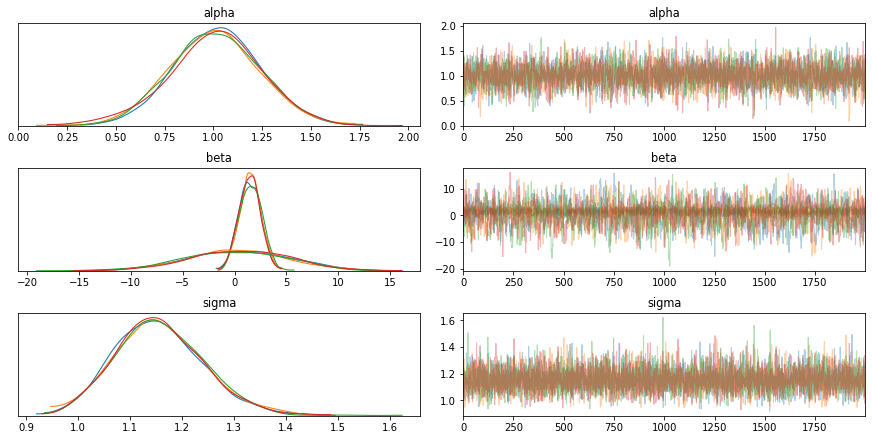

In [60]:
traceplot(trace)

We will look at the summary of the sampling process. The columns will be explained as we progress through this course.

In [20]:
az.summary(trace)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha    1.008  0.229   0.557    1.419      0.004    0.003    3976.0  3976.0   
beta[0]  1.482  1.044  -0.438    3.441      0.028    0.020    1426.0  1426.0   
beta[1]  0.264  4.847  -8.781    9.343      0.130    0.092    1397.0  1397.0   
sigma    1.155  0.085   0.993    1.312      0.001    0.001    7311.0  7125.0   

         ess_bulk  ess_tail  r_hat  
alpha      4009.0    3701.0    1.0  
beta[0]    1425.0    1760.0    1.0  
beta[1]    1398.0    2042.0    1.0  
sigma      7574.0    6080.0    1.0

In [21]:
from pymc3 import summary
summary(trace)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha    1.008  0.229   0.557    1.419      0.004    0.003    3976.0  3976.0   
beta[0]  1.482  1.044  -0.438    3.441      0.028    0.020    1426.0  1426.0   
beta[1]  0.264  4.847  -8.781    9.343      0.130    0.092    1397.0  1397.0   
sigma    1.155  0.085   0.993    1.312      0.001    0.001    7311.0  7125.0   

         ess_bulk  ess_tail  r_hat  
alpha      4009.0    3701.0    1.0  
beta[0]    1425.0    1760.0    1.0  
beta[1]    1398.0    2042.0    1.0  
sigma      7574.0    6080.0    1.0

### Composition of Distributions for Uncertainty

You can do the same without observations, to perform computations and get uncertainty quantification. In this example add two normally distributed variables to get another normally distributed variable. By definition

$$\mu_c = \mu_a + \mu_b $$

$$\sigma_c^2 = \sigma_a^2 + \sigma_b^2$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_obs, sigma, beta, alpha]
Sampling 4 chains, 19 divergences: 100%|██████████| 62000/62000 [00:15<00:00, 4058.26draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882730362833375, but should be close to 0.8. Try to increase the number of tuning steps.


[[32.09431669]
 [32.25815932]
 [32.85080701]
 ...
 [34.50857964]
 [26.83640328]
 [35.88096126]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc30e1681f0>,
      dtype=object)

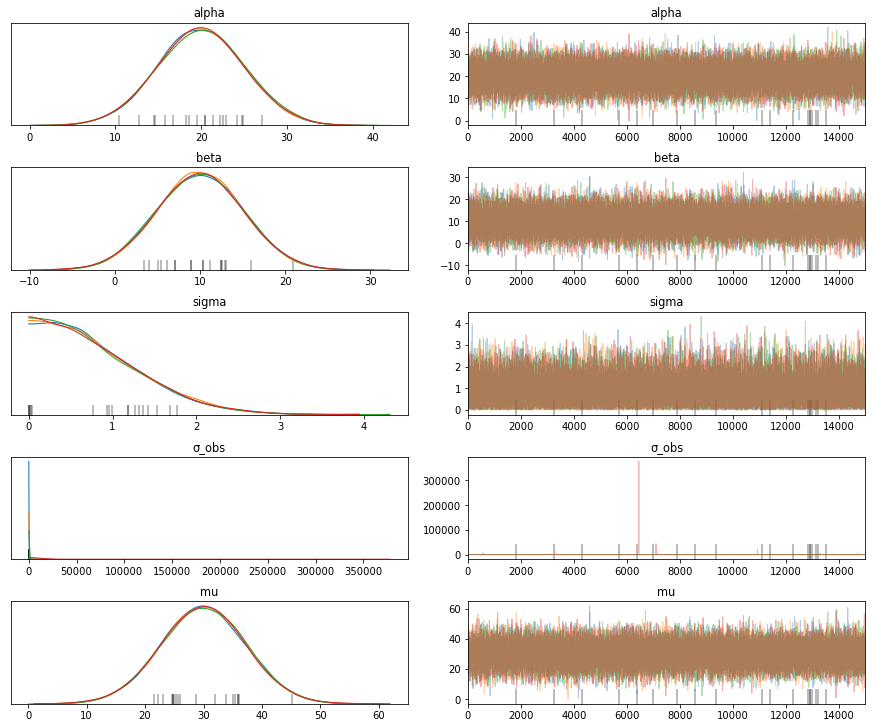

In [63]:
basic_model2 = Model()

with basic_model2:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=20, sd=5)
    beta = Normal('beta', mu=10, sd=5, shape=1)
    # These aren't used in the calculation, but please experiment by composing various combinations
    # of these function for calculating mu
    sigma = HalfNormal('sigma', sd=1)
    σ_obs = pm.HalfCauchy("σ_obs", beta=1, testval=0.1)

    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha + beta) 
    
    trace = sample(15000)
    
print(trace['mu'])
traceplot(trace)    

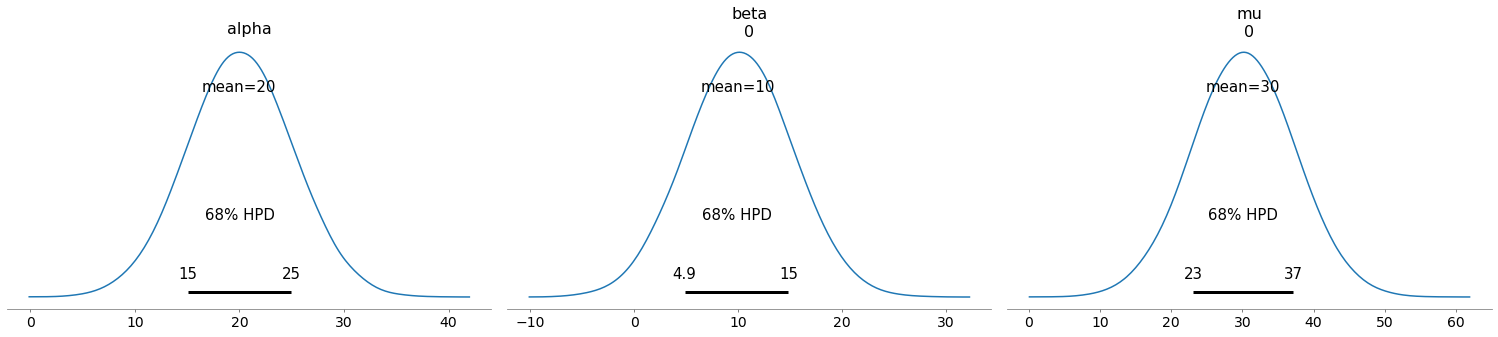

In [73]:
# Note the mean and standard deviation of the variable mu. We didn't need observations to compute this uncertainty.
try:
    # older syntax
    pm.plot_posterior(trace, var_names=['alpha', 'beta', 'mu'], credible_interval=0.68)
except:
    pm.plot_posterior(trace, var_names=['alpha', 'beta', 'mu'], hdi_prob=0.68)

### GRADED EVALUATION (5 mins)

1. What type of algorithms does PyMC3 support?

   a. MCMC
   
   b. Variational Inference
   
   c. Both (C)
   
   
2. We can mix Deterministic and Probabilistic variables in PyMC3

   a. True (C)
   
   b. False

#### HPD, Credible Interval, HDI and ROPE

##### What is it used for?

HDI, HPD and ROPE are essentially used for making decisions from the posterior distribution.

##### HPD and Credible Interval

For example, if we plot the posterior of a beta distribution with some parameters, the credible interval for the Highest Posterior Density (HPD) is the **shortest** interval that has the given probability indicated by the HPD. This interval is also called the HPD interval. As the name indicates, this involves regions of the highest posterior probability density. For unimodal distributions, this includes the mode.


![HPD](images/HPDI_1.png)

<center>x% HPD interval</center>

![HPD](images/HPDI_2.png)

<center>x% HPD interval</center>


##### HDI

A related term is the Highest Density Interval (HDI) which is a more general term that can apply for any distribution such as a prior and not just the posterior. In other words a posterior's HDI is called the HPD interval. 

As an example, if we suspect that the dice used at a casino is loaded, we can infer the probability of getting the value 3 from the six possible outcomes. Ideally, this should be 1/6 = 0.16666. If this happens to fall in the HPD interval, we can assume that the dice is fair however it may be that the distribution may be biased to one side or the other.  


##### ROPE

What is the probability of getting a value given by x? We can't really calculate this exactly but we can compute this probability within a range given by x + $\Delta$x, x - $\Delta$x. 

![HPD](images/HPD.png)

<center><i>Probability of getting values less than x, and a range of values around x</i></center>


Sometimes, instead of looking at the probability that x = 0.16666, we look at the probability that it falls within the range 0.12 and 0.20. This range is called the Region of Practical Equivalence or ROPE. This implies that, based on our subjective opinion, getting a value between 0.12 and 0.20 is practically equivalent to getting a 0.16666. Hence, we can assume that the dice is fair given any value within this range. ROPE allows us to make decisions about an event from an inferred posterior distribution. After computing the posterior, the ROPE given by 0.12 and 0.20 can either overlap with the HPD (of getting a 3)  

* completely
* not overlap at all 
* partially overlap with the HPD

Complete overlap suggests that our computed probability coincides with what we would expect from a fair dice. If it does not overlap, it is not a fair dice and a partial overlap indicates that we cannot be certain that is either fair or unfair.

In short, we define a ROPE based on our subject matter expertise and compare it to the HPD to make a decision from the posterior distribution.

##### Credible intervals vs. Confidence Intervals

This deserves special mention particularly due to the subtle differences stemming from the Bayesian (credible intervals) vs. Frequentist (confidence intervals) approaches involved. Bayesians consider the parameters to be a distribution, and for them there is no true parameter. However, Frequentists fundamentally assume that there exists a true parameter. 

* Confidence intervals quantify our confidence that the true parameter exists in this interval. It is a statement about the interval.
* Credible intervals quantify our uncertainty about the parameters since there are no true parameters in a Bayesian setting. It is a statement about the probability of the parameter.

For e.g. if we are trying to estimate the R0 for COVID-19, one could say that we have a 95% confidence interval of the true R0 being between 2.0 and 3.2. In a Bayesian setting, the 95% credible interval of (2, 3.2) implies that 95% of the possible R0 values fall between 2.0 and 3.2.

We will see how we can visualize the following using ArViz

* HDI (Black lines)
* ROPE (Green lines)

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

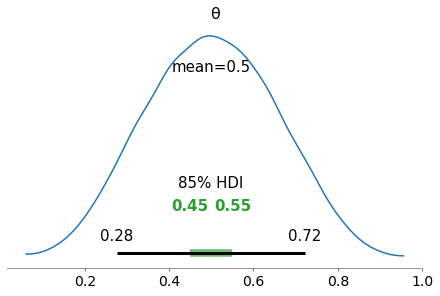

In [316]:
import numpy as np
from scipy import stats as stats 

np.random.seed(1)

try:
    az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)},
                  credible_interval=0.75,                    # defaults to 94%
                  #hdi_prob = 0.85,  
                  rope =[0.45, 0.55])
except:                      
    az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)},
                      #credible_interval=0.75,                    # defaults to 94%
                      hdi_prob = 0.85,                            # credible_interval is deprecated, use hdi_prob
                      rope =[0.45, 0.55])

Another way to do this is by plotting a reference value on the posterior. Below, a reference value of 0.48 is used and it can be seen that 45.2% of the posterior is below this value while 54.8% of the posterior is above this value. If we were estimating our parameter to have a value of 0.48, this suggests a good fit but with a slight right bias or in other words that the parameter is likely to have a value greater than 0.48.

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

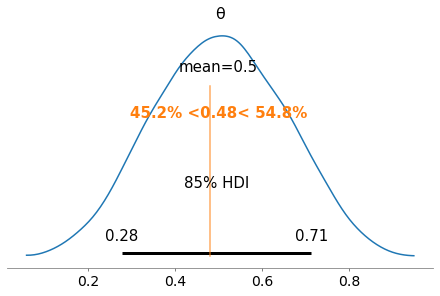

In [317]:
try:
    az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)},
                  credible_interval=0.75,                    # defaults to 94%
                  #hdi_prob = 0.85,                            # credible_interval is deprecated, use hdi_prob
                  ref_val=0.48)
except:
    az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)},
                      #credible_interval=0.75,                    # defaults to 94%
                      hdi_prob = 0.85,                            # credible_interval is deprecated, use hdi_prob
                      ref_val=0.48)

### Graded Evaluation (15 min)

1. HDI and HPD are the same

   a. True
   
   b. False (C)
   
2. HPD is used for making decisions from the posterior distribution

   a. True (C)
   
   b. False 
   
3. ROPE is a subjective but informed interval to help make decisions from the posterior distribution

   a. True
   
   b. False
   
4. In order to confirm our hypothesis that we have the right estimate for our parameter, we want our ROPE and the HPD to have

   a. complete overlap (C)
   
   b. partial overlap
   
   c. no overlap
   
5. A reference value can be used to indicate tge direction of bias in our posterior dsitribution

   a. True (C)
   
   b. False
   
<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Modeling with a Gaussian Distribution

Gaussians (Normal distributions) are normally used to approximate a lot of practical data distributions. Some of the reasons for this are: 

* The Central Limit Theorem, which states: 

   ```The distribution of the sample means will be a normal distribution```

   [Intuitive explanation of the Central Limit Theorem](https://statisticsbyjim.com/basics/central-limit-theorem/)

   which implies that if we take the mean of the sample means, we should get the true population mean. 

* A more subtle reason for adopting the Gaussian distribution to represent a lot of phenomena is the fact that a lot of these phenomena themselves are a result of averages of varying factors. 

* Mathematical tractability of the distribution - it is easy to compute in closed form. While not every distribution can be approximated with a single Gaussian distribution, we can use a mixture of Gaussians to represent other multi-modal distributions.

The probability density for a Normal distribution in a single dimension is given by:

$p(x) = \dfrac{1}{\sigma \sqrt{2 \pi}} e^{-(x - \mu)^2 / 2 \sigma^2}$

where $\mu$ is the mean and $\sigma$ is the standard deviation. In higher dimensions, we have a vector of means and a covariance matrix. 

#### Example with PyMC3

We read the chemical shifts data, and plot the density to get an idea of 
the data distribution. It looks somewhat like a Gaussian so maybe we can start
there. We have two parameters to infer, that is the mean and the standard deviation. 
We can estimate a prior for the mean by looking at the density and putting 
some bounds using a uniform prior. The standard deviation is however chosen to 
have a mean-centered half-normal prior (half-normal since the standard deviation 
cannot be negative). We can provide a hyperparameter for this by inspecting the
density again. These values decide how well we converge to a solution so good 
values are essential for good results. 

([<matplotlib.axis.YTick at 0x7fc30d00f160>],
 <a list of 1 Text major ticklabel objects>)

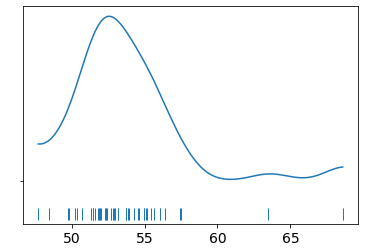

In [77]:
data = np.loadtxt('data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

In [75]:
data

array([55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65, 51.49,
       51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48, 57.44,
       55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94,
       54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82, 54.99,
       52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3 ,
       53.84, 53.16])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1602.44draws/s]


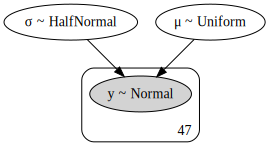

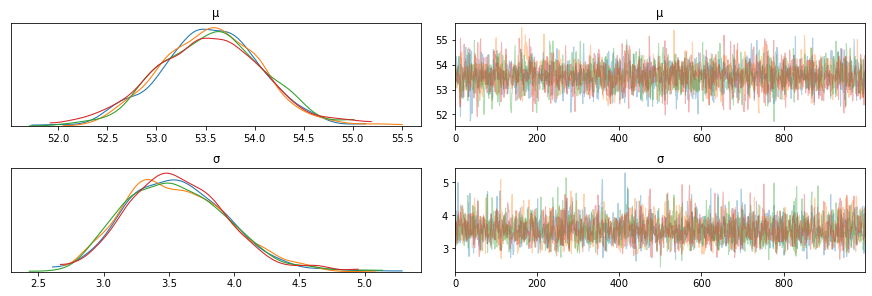

In [76]:
import pymc3 as pm
from pymc3.backends import SQLite, Text
model_g = Model()

with model_g:
    
    #backend = SQLite('test.sqlite')
    db = pm.backends.Text('test')
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(draws=1000) # backend = SQLite('test.sqlite') - Does not work

az.plot_trace(trace_g)
pm.model_to_graphviz(model_g)    

<br>
<br>
<hr style="border:2px green solid "> </hr>

##### Note on scalablility 
If your trace information is too big as a result of too many variables or the model being large, you do not want to store this in memory since it can overrun the machine memory. Persisting this in a DB will allow you to reload it and inspect it at a later time as well. For each run, it appends the samples to the DB (or file if not deleted).

In [334]:
help(pm.backends)

Help on package pymc3.backends in pymc3:

NAME
    pymc3.backends - Backends for traces

DESCRIPTION
    Available backends
    ------------------
    
    1. NumPy array (pymc3.backends.NDArray)
    2. Text files (pymc3.backends.Text)
    3. SQLite (pymc3.backends.SQLite)
    
    The NDArray backend holds the entire trace in memory, whereas the Text
    and SQLite backends store the values while sampling.
    
    Selecting a backend
    -------------------
    
    By default, a NumPy array is used as the backend. To specify a different
    backend, pass a backend instance to `sample`.
    
    For example, the following would save the sampling values to CSV files
    in the directory 'test'.
    
        >>> import pymc3 as pm
        >>> with pm.Model():
        >>>      db = pm.backends.Text('test')
        >>>      trace = pm.sample(..., trace=db)
    
    Note that as in the example above, one must have an active model context,
    or pass a `model` parameter in order to create

In [24]:
from pymc3.backends.sqlite import load

with model_g:
    #trace = pm.backends.text.load('./mcmc')
    trace = pm.backends.sqlite.load('./mcmc.sqlite')
    
print(len(trace['μ']))

71000


<br>
<br>
<hr style="border:2px green solid "> </hr>

#### Pairplot for Correlations

Use a pairplot of the parameters to ensure that there are no correlations that would adversely affect the sampling process.

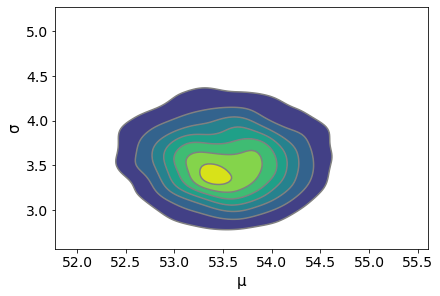

In [25]:
az.plot_pair(trace_g, kind='kde', fill_last=False)

In [27]:
az.summary(trace_g)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  53.524  0.544  52.504   54.513      0.010    0.007    2716.0  2716.0   
σ   3.564  0.389   2.877    4.320      0.007    0.005    2902.0  2755.0   

   ess_bulk  ess_tail  r_hat  
μ    2708.0    2008.0    1.0  
σ    3059.0    2413.0    1.0

#### Posterior Predictive Check

We can draw samples from the inferred posterior distribution to check to see how they line up with the observed values. Below, we draw 100 samples of length corresponding to that of the data from this posterior. You are returned a dictionary for each of the observed variables in the model. 

In [78]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
print("Shape of the sampled variable y and data ",np.shape(y_pred_g['y']), len(data))

100%|██████████| 100/100 [00:00<00:00, 998.82it/s]

Shape of the sampled variable y and data  (100, 47) 47


In [79]:
y_pred_g['y'][0]

array([45.53260993, 54.10289681, 48.66040023, 53.77971592, 56.46850139,
       53.04692598, 58.67379494, 53.78900017, 49.40837911, 53.89149333,
       50.7769683 , 52.76403229, 56.49493798, 49.45154213, 50.9368833 ,
       52.15412225, 53.68402289, 54.5480772 , 55.48493177, 50.47109214,
       60.26921123, 63.47612414, 52.57626571, 55.85031574, 57.09879031,
       53.60009516, 53.60991658, 57.54224547, 54.01678025, 55.67096381,
       53.68052361, 53.62875786, 56.11198038, 48.00436409, 53.1587586 ,
       55.4568336 , 54.16217932, 54.45011005, 59.10133838, 52.74692729,
       57.09680258, 63.12037032, 56.84681701, 52.67425532, 59.41026027,
       49.80051262, 53.30718519])

You can also plot the distribution of these samples by passing this variable 'y_pred_g' as shown below. Setting `mean=True` in the call to `plot_ppc` computes the mean distribution of the 100 sampled distributions and plots it as well.

arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


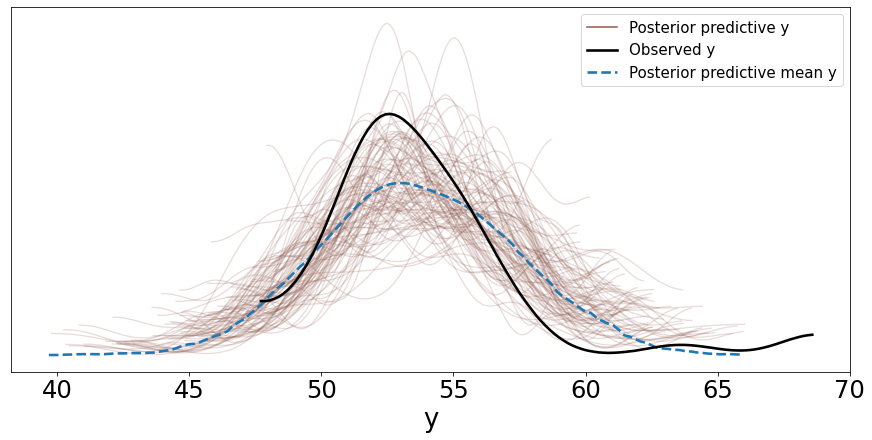

In [80]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
ax[0].legend(fontsize=15)

Two things can be noted here:

* The mean distribution of the samples from the posterior predictive distribution is close to the distribution of the observed data but the mean of this mean distribution is slightly shifted to the right.

* Also, the variance of the samples; whether we can say qualitatively that this is acceptable or not depends on the problem. In general, the more representative data points available to us, the lower the variance.

Another thing to note here is that we modeled this problem using a Gaussian distribution, however we have some outliers that need to be accounted for which we cannot do well with a Gaussian distribution. We will see below how to use a Student's t-distribution for that.

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Robust Models with a Student's t-Distribution

As mentioned in the previous section, one of the issues with assuming a Gaussian distribution is the assumption of finite variance. When you have observed data that lies outside this 'boundary', a Gaussian distribution is not a good fit and PyMC3, and other MCMC-based tools will be unable to reconcile these differences appropriately.

This distribution is parameterized by the following:

* μ corresponds to the mean of the distribution
    
* σ is the scale and corresponds roughly to the standard deviation

* ν is the degrees of freedom and takes values between 0 and $\infty$. The degrees of freedom corresponds to the number of independent observations minus 1. When the sample size is 8, the t-distribution used to model this would have degrees of freedom set to 7. A value of 1 corresponds to the Cauchy distribution and indicates heavy tails, while infinity corresponds to a Normal distribution. 

The probability density function for a zero-centered Student's t-distribution with scale set to one is given by:

$p(t) = \dfrac{\gamma ((v+1) / 2)}{\sqrt{v \pi} \gamma (v/2)} (1 + \dfrac{t^2}{v})^{-(v+1)/2}$

In this case, the mean of the distribution is 0 and the variance is given by ν/(ν - 2).

Now let us model the same problem with this distribution instead of a Normal.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1461.34draws/s]


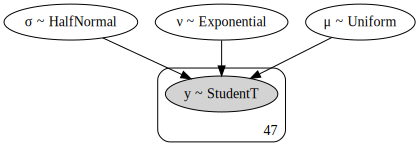

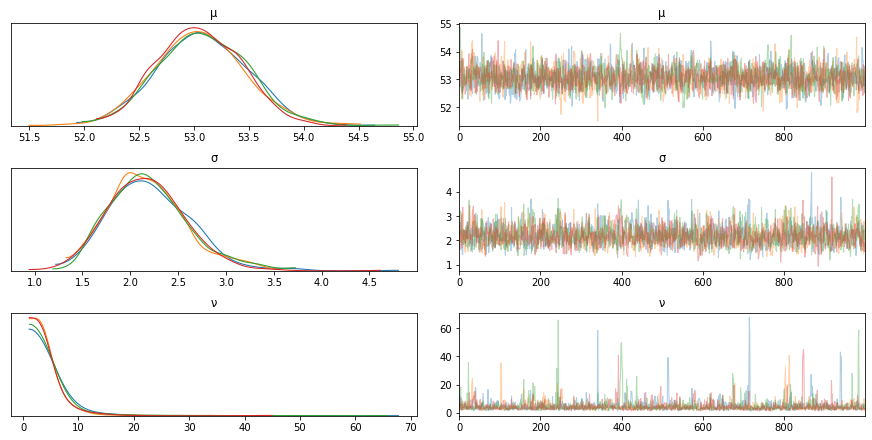

In [81]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75) # mean
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

az.plot_trace(trace_t)
pm.model_to_graphviz(model_t)    

Using a student's t-distribution we notice that the outliers are captured more accurately now and the model fits better.

100%|██████████| 100/100 [00:00<00:00, 1263.33it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

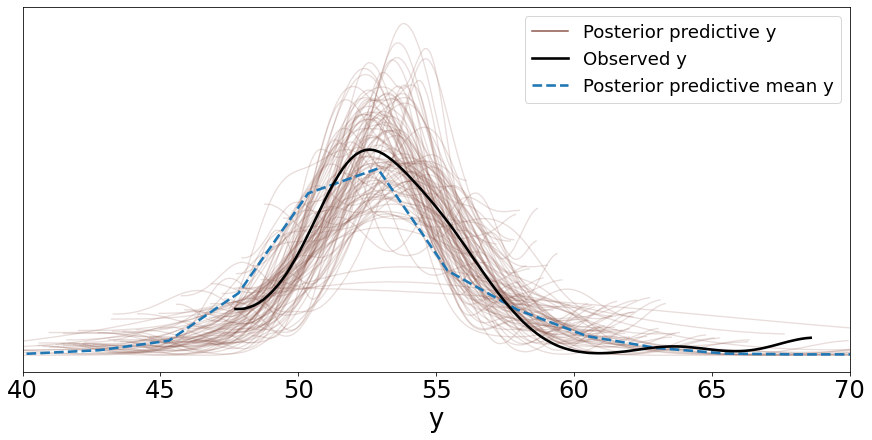

In [82]:
# Using a student's t distribution we notice that the outliers are captured more 
# accurately now and the model fits better
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=True)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

### Reading - Bayesian Estimation to Determine the Effectiveness of Drugs 

https://docs.pymc.io/notebooks/BEST.html

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Hierarchical Models or Multilevel Models

Suppose we want to perform an analysis of water quality in a state and information is available from each district in the state. There are two ways to model this now: 

* We can study each district separately, however we lose information especially if there is insufficient data for some districts. But we get a more detailed model per district.

* The second option is to combine all the data and estimate the water quality of the state as a whole, i.e. a pooled model. We have more data but we lose granular information about each district.

The hierarchical model combines both of these options, by sharing information between the districts using hyperpriors that are priors over the parameter priors. In other words, instead of setting the prior parameters (or hyperparameters) to a constant value, we draw it from another prior distribution called the hyperprior. This hyperprior is shared among all the districts, and as a result information is shared between all the groups in the data.

#### Problem Statement

We measure the water samples for three districts, and we collect 30 samples for each district. The data is simply a binary value that indicates whether the water is contaminated or not. We count the number of samples that have contamination below the acceptable levels. We generate three arrays:

* N_samples - The total number of samples collected for each district or group
* G_samples - The number of good samples or samples with contamination levels below a certain threshold
* group_idx - The id for each district or group

#### Artifically generate the data

In [83]:
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 18, 18] # Number of samples with water contamination 
                         # below accepted levels
# Create an ID for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))


In [84]:
# ID per sample
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [362]:
data

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### The Sampling Model

The scenario presented here is essentially a binary classification problem that can be modeled using a Bernoulli distribution. The parameter of the Bernoulli distribution is a vector corresponding to each group (\\(\theta_1, \theta_2, \theta_3\\)) and indicates the probability of getting a good sample (in each group). Since this is a hierarchical model, each group shares information and as a result the parameter of Group 1 can be influenced by the samples in Group 2 and 3. This is what makes hierarchical modeling so powerful. 

The process of generating our samples looks like the following. If we start from the last equation and work our way up, we can see that $\theta_i$ and $y_i$ are similar to a pooled model except that the beta prior takes parameters $\alpha$ and $\beta$ instead of constant values. These parameters now have hyperpriors applied to them using the parameters $\mu$ and *k* which are assumed to be distributed using a beta distribution and a half-Normal distribution respectively. Note that $\alpha$ and $\beta$ are indirectly computed from the terms \\(\mu\\) and *k* here. \\(\mu\\) affects the mean of the beta distribution and increasing *k* makes the beta distribution more concentrated. This parameterization is more efficient than the direct parameterization in terms of $\alpha_i$ and $\beta_i$.


$$ \mu \sim Beta(\alpha_p, \beta_p)  $$
$$ k \sim | Normal(0,\sigma_k) | $$
$$  \alpha =  \mu * k $$
$$  \beta = (1 - \mu) * k $$
$$  \theta_i \sim Beta(\alpha, \beta) $$
$$  y_i \sim Bern(\theta_i) $$




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:15<00:00, 657.97draws/s]


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ       0.583  0.095   0.412    0.766      0.001    0.001    5915.0  5915.0   
κ      12.412  6.265   1.931   23.805      0.084    0.059    5625.0  5625.0   
alpha   7.284  3.905   0.716   14.192      0.052    0.037    5633.0  5633.0   
beta    5.128  2.793   0.662   10.095      0.037    0.026    5603.0  5603.0   
θ[0]    0.598  0.080   0.445    0.742      0.001    0.001    6702.0  6567.0   
θ[1]    0.597  0.080   0.445    0.743      0.001    0.001    6390.0  6330.0   
θ[2]    0.597  0.078   0.453    0.743      0.001    0.001    6441.0  6325.0   

       ess_bulk  ess_tail  r_hat  
μ        5940.0    5481.0    1.0  
κ        5070.0    4299.0    1.0  
alpha    4991.0    4178.0    1.0  
beta     5097.0    4733.0    1.0  
θ[0]     6649.0    5038.0    1.0  
θ[1]     6359.0    5490.0    1.0  
θ[2]     6413.0    5425.0    1.0  


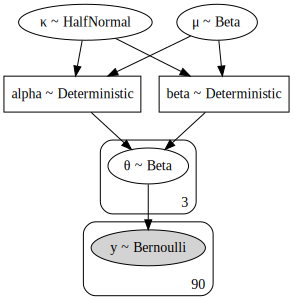

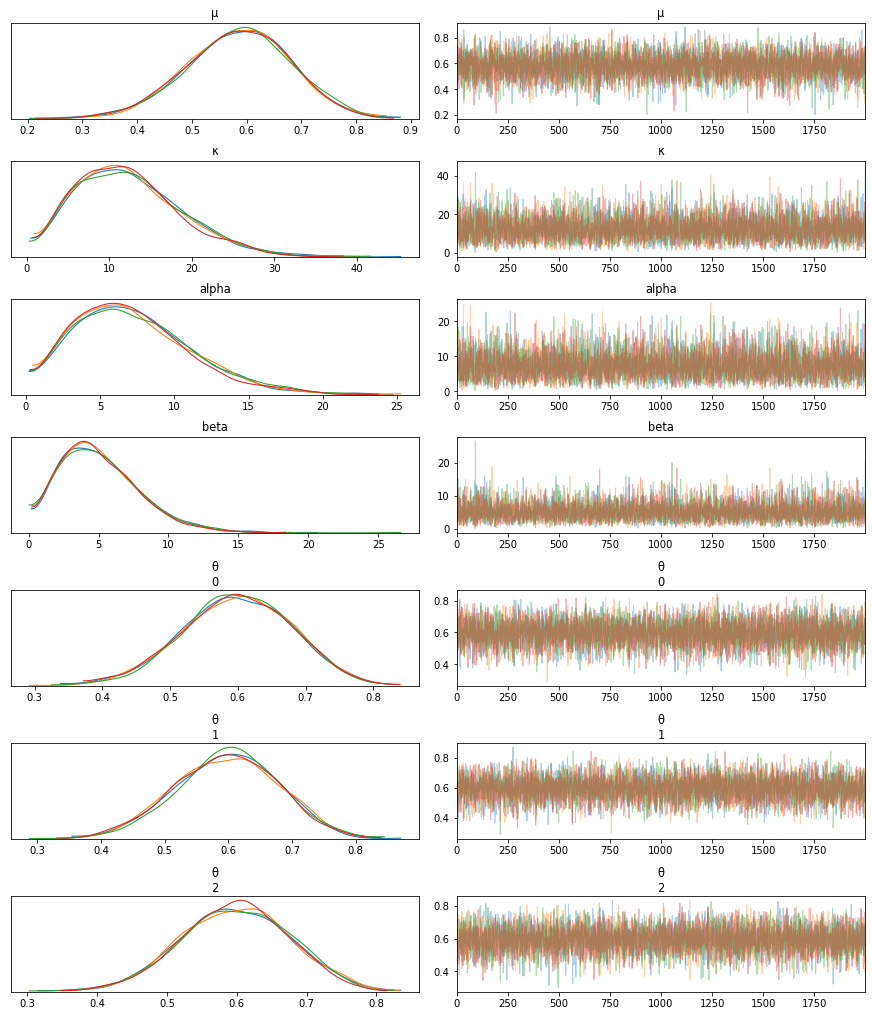

In [87]:
def get_hyperprior_model(data, N_samples, group_idx):
    with pm.Model() as model_h:
        μ = pm.Beta('μ', 1., 1.) # hyperprior
        κ = pm.HalfNormal('κ', 10) # hyperprior
        alpha = pm.Deterministic('alpha', μ*κ)
        beta = pm.Deterministic('beta', (1.0-μ)*κ)
        θ = pm.Beta('θ', alpha=alpha, beta=beta, shape=len(N_samples)) # prior, len(N_samples) = 3
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        trace_h = pm.sample(2000)
    az.plot_trace(trace_h)
    print(az.summary(trace_h))
    return(model_h)    
    
model = get_hyperprior_model(data, N_samples, group_idx)
pm.model_to_graphviz(model)

#### Shrinkage

Shrinkage refers to the phenomenon of sharing information among the groups through the use of hyperpriors. Hierarchical models can therefore be considered partially pooled models since information is shared among the groups so we move away from extreme values for the inferred parameters. This is good for two scenarios:

* If we have outliers (or poor quality data) in our data groups. 
* If we do not have a lot of data. 

In hierarchical models, the groups are neither independent (unpooled) nor do we clump all the data together (pooled) without accounting for the differences in the groups. 

We can look at three cases below as examples to illustrate the benefits of a hierarchical model. We keep the total number of samples and groups the same as before, however we vary the number of good samples in each group. When there are significant differences in the number of good samples within the groups, the behavior is different from what we see in an independent model. Averages win and extreme values are avoided.

The values of G_samples are changed to have the following values

1. [5,5,5]
2. [18,5,5]
3. [18,18,1]

Note how the values of the three $\theta$s change as we change the values of G_samples.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ      0.219  0.083   0.077    0.371      0.001    0.001    4711.0  4129.0   
κ     12.114  6.257   1.954   23.998      0.080    0.056    6145.0  6145.0   
θ[0]   0.179  0.062   0.072    0.297      0.001    0.001    6626.0  6626.0   
θ[1]   0.178  0.063   0.070    0.296      0.001    0.001    6208.0  6196.0   
θ[2]   0.179  0.062   0.073    0.301      0.001    0.001    6149.0  6149.0   

      ess_bulk  ess_tail  r_hat  
μ       5071.0    4573.0    1.0  
κ       5449.0    4138.0    1.0  
θ[0]    6257.0    5240.0    1.0  
θ[1]    6058.0    5071.0    1.0  
θ[2]    5894.0    4777.0    1.0  


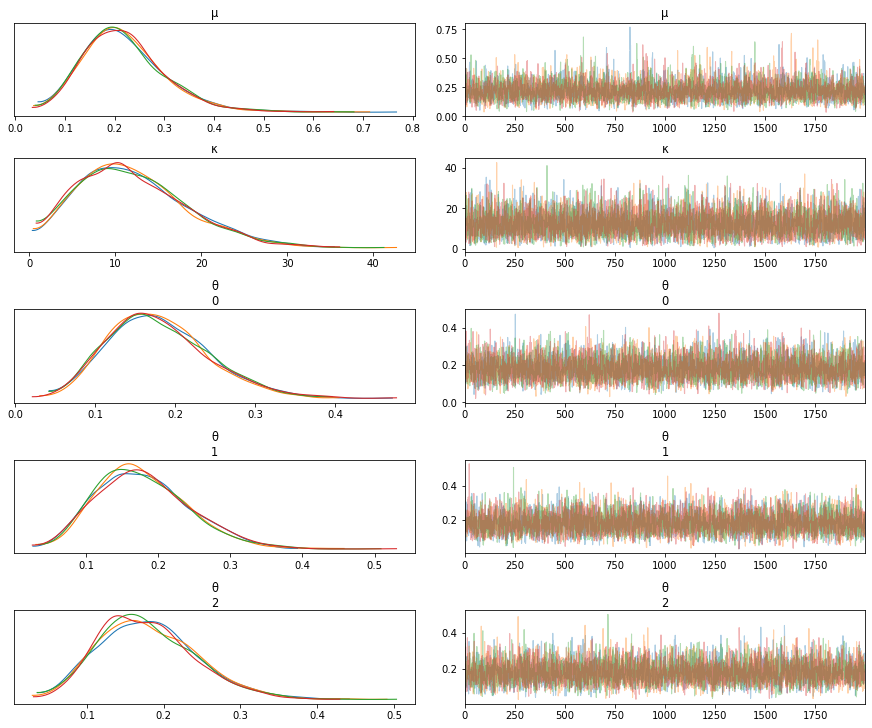

In [372]:
# Case 1
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [5, 5, 5] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

model = get_hyperprior_model(data, N_samples, group_idx)
model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ     0.340  0.110   0.130    0.534      0.002    0.001    5276.0  4919.0   
κ     7.385  4.552   0.755   15.699      0.069    0.049    4299.0  4299.0   
θ[0]  0.550  0.088   0.389    0.714      0.001    0.001    5232.0  5213.0   
θ[1]  0.196  0.068   0.072    0.320      0.001    0.001    5489.0  5489.0   
θ[2]  0.196  0.067   0.076    0.321      0.001    0.001    4750.0  4750.0   

      ess_bulk  ess_tail  r_hat  
μ       5436.0    5137.0    1.0  
κ       4053.0    4706.0    1.0  
θ[0]    5227.0    5154.0    1.0  
θ[1]    5250.0    4633.0    1.0  
θ[2]    4585.0    4605.0    1.0  


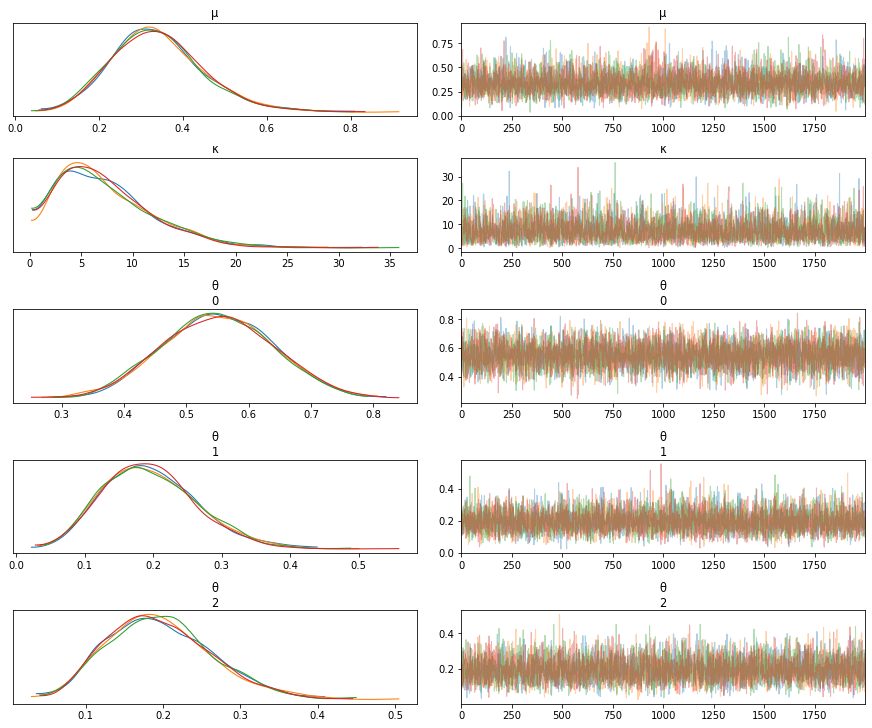

In [366]:
# Case 2 - The value of theta_1 is now smaller compared to our original case
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 5, 5] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

get_hyperprior_model(data, N_samples, group_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ     0.398  0.129   0.156    0.638      0.002    0.001    5504.0  5218.0   
κ     4.058  2.846   0.280    9.217      0.044    0.034    4167.0  3573.0   
θ[0]  0.577  0.087   0.419    0.740      0.001    0.001    6018.0  6005.0   
θ[1]  0.576  0.087   0.416    0.738      0.001    0.001    5558.0  5450.0   
θ[2]  0.075  0.051   0.001    0.165      0.001    0.001    5150.0  4729.0   

      ess_bulk  ess_tail  r_hat  
μ       5575.0    5216.0    1.0  
κ       4547.0    3757.0    1.0  
θ[0]    6013.0    5153.0    1.0  
θ[1]    5535.0    4996.0    1.0  
θ[2]    5056.0    4368.0    1.0  


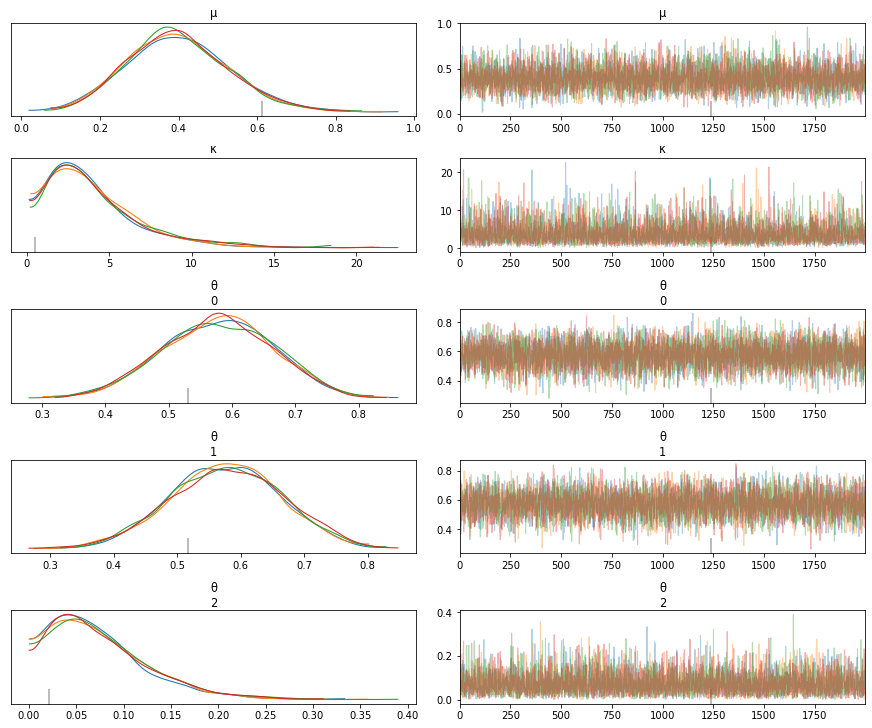

In [367]:
# Case 3 - Value of theta_3 is not as small as it would have been if it were estimated individually
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 18, 1] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

get_hyperprior_model(data, N_samples, group_idx)

### GRADED EVALUATION (18 mins)

1. According to the Central Limit Theorem, the mean of the sample means tends to the true population mean as the number of samples increase

    a. True (C)

    b. False
    
    
2. Many real-world phenomena are averages of various factors, hence it is reasonable to use a Gaussian distribution to model them

    a. True (C)
    
    b. False 
    
    
3. What type of distribution is better suited to modeling positive values?

    a. Normal
    
    b. Half-normal (C)
    
    
4. Posterior predictive checks can be used to verify that the inferred distribution is similar to the observed data

    a. True (C)
    
    b. False
    
    
5. Which distribution is better suited to model data that has a lot of outliers?

    a. Gaussian distribution
    
    b. Student's t-distribution (C)
    
    
6. Hierarchical models are beneficial in modeling data from groups where there might be limited data in certain groups

    a. True (C)
    
    b. False
    
  
7. Hierarchical models share information through hyperpriors

    a. True (C)
    
    b. False

<br>
<br>
<hr style="border:2px solid blue"> </hr>


### Linear Regression Again!

Let us generate some data for linear regression and plot it along with its density. 

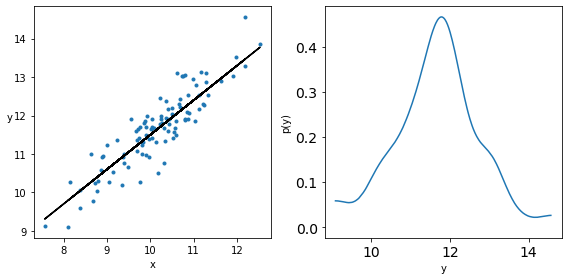

In [48]:
np.random.seed(1)
N = 100

# Parameters
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

# Input data drawn from a Normal distribution
x = np.random.normal(10, 1, N)

# Output generated from the input and the parameters
y_real = alpha_real + beta_real * x

# Add random noise to y
y = y_real + eps_real

# Plot the data
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
ax[1].set_ylabel('p(y)')
plt.tight_layout()


#### Inference of Parameters in Linear Regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


<Figure size 432x288 with 0 Axes>

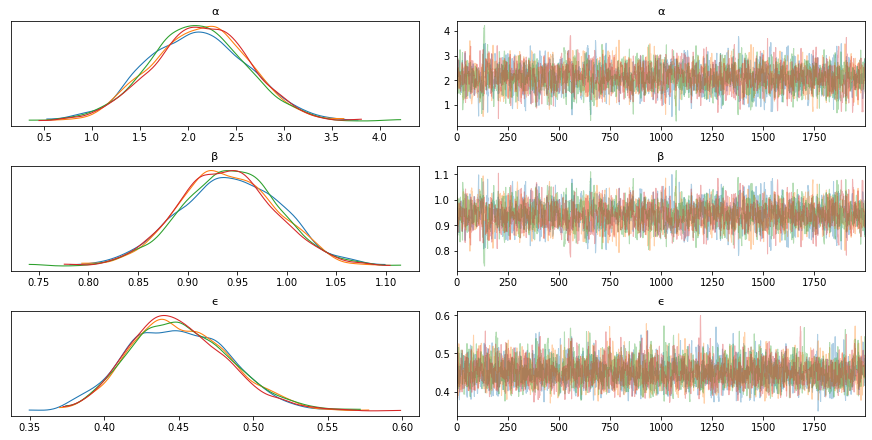

<Figure size 432x288 with 0 Axes>

In [49]:
import pymc3 as pm

with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5) # Try changing this to a half normal, half cauchy has fatter tails
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_g = pm.sample(2000, tune=1000)
    
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ']) # if you have a lot of variables, explicitly specify
plt.figure()


#### Parameter Correlations

<AxesSubplot:xlabel='α', ylabel='β'>

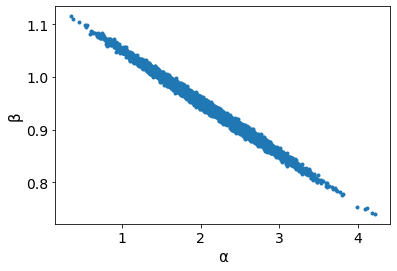

In [50]:
# Pairplot
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1}) # Notice the diagonal shape

#### Visualize the Uncertainty

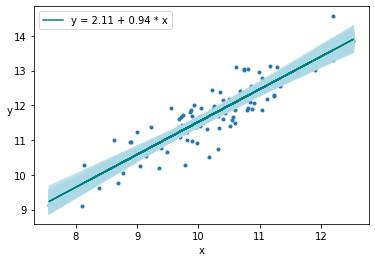

In [52]:
plt.figure()
# Plot the true values
plt.plot(x, y, 'C0.') 

# Get the mean inferred values
alpha_m = trace_g['α'].mean() 
beta_m = trace_g['β'].mean()  

# Plot all draws to show the variance of the regression lines
draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]* x[:, np.newaxis], c='lightblue', alpha=0.5)

# Plot the mean regression line
plt.plot(x, alpha_m + beta_m * x, c='teal', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

####  Posterior Sampling

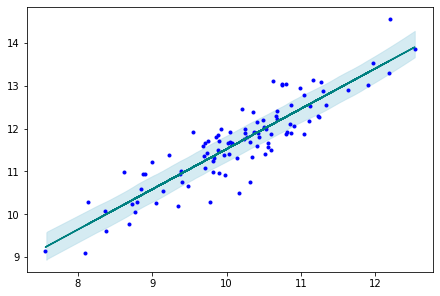

In [55]:
ppc = pm.sample_posterior_predictive(trace_g,
                                     samples=2000,
                                     model=model_g)


# Plot the posterior predicted samples, i.e. these are samples of predicted y for each original x in our data
az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='lightblue')

# Plot the true y values
plt.plot(x, y, 'b.') 

# Plot the mean regression line - from cell above
plt.plot(x, alpha_m + beta_m * x, c='teal') 

#### Mean-center the Data

Looking at the pairplot of $\alpha$ and $\beta$, one can notice the high degree of correlation between these two variables as indicated by the narrow joint density. This results in a parameter posterior space that is diagonally shaped, which is problematic for many samplers such as the Metropolis-Hastings MCMC sampler. One recommended approach to minimize this correlation is to center the independent variables. If \\(\bar{x}\\) is the mean of the data x then

$$\tilde{x} = x - \bar{x}$$

The advantage of this is twofold:

1. The pivot point is the intercept when the slope changes
2. The parameter posterior space is more circular

##### Transformation

In order to center the data, the original equation for linear regression given by

$$y = \alpha + \beta x$$

has to be equivalent to the equation for the centered data

$$y = \tilde{\alpha} + \tilde{\beta}(x - \bar{x}) = \tilde{\alpha} - \tilde{\beta} \bar{x} + \tilde{\beta} x$$


##### Recovering the data

This implies that we can recover the original intercept \\(\alpha\\) as

$$ \alpha = \tilde{\alpha} - \tilde{\beta} \bar{x}$$

and \\(\beta\\) as

$$ \beta = \tilde{\beta} $$


#### Standardize the data

You can also standardize the data by mean centering and dividing by the standard deviation

$$\tilde{x} = (x - \bar{x}) / \sigma_x$$

#### Mean Centered - Broader Sampling Space

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2088.47draws/s]


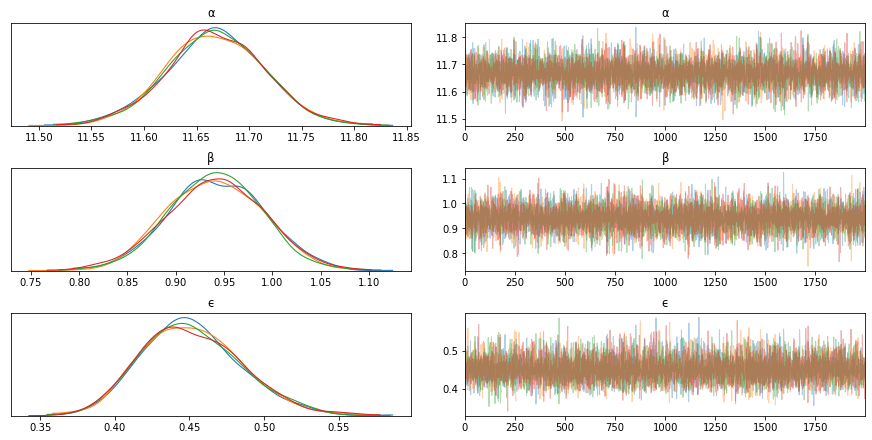

<Figure size 432x288 with 0 Axes>

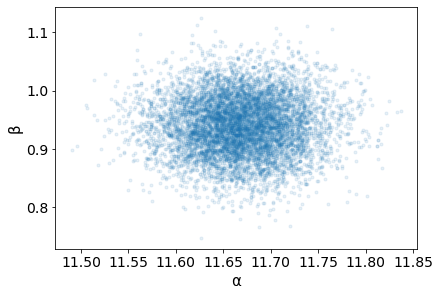

In [100]:
# Center the data
x_centered = x - x.mean()

with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_centered)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    α_recovered = pm.Deterministic('α_recovered', α - β * x.mean())
    trace_g = pm.sample(2000, tune=1000)
    
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])
plt.figure()
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

### Robust Linear Regression

We fitted our model parameters by assuming the data likelihood was a Normal distribution, however as we saw earlier this assumption suffers from not doing well with outliers. Our solution to this problem is the same, use a Student's t-distribution for the likelihood.

Here we look at the [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), which is a set of 4 data sets. They have similar statistical properties even though they look very different and were used to illustrate the need to visualize the data along with the effect of outliers. Our intended goal is the same, to model data with outliers and assess the sensitivity of the model to these outliers.

In [58]:
import seaborn as sns
from scipy import stats

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")
df

dataset     x      y
0        I  10.0   8.04
1        I   8.0   6.95
2        I  13.0   7.58
3        I   9.0   8.81
4        I  11.0   8.33
5        I  14.0   9.96
6        I   6.0   7.24
7        I   4.0   4.26
8        I  12.0  10.84
9        I   7.0   4.82
10       I   5.0   5.68
11      II  10.0   9.14
12      II   8.0   8.14
13      II  13.0   8.74
14      II   9.0   8.77
15      II  11.0   9.26
16      II  14.0   8.10
17      II   6.0   6.13
18      II   4.0   3.10
19      II  12.0   9.13
20      II   7.0   7.26
21      II   5.0   4.74
22     III  10.0   7.46
23     III   8.0   6.77
24     III  13.0  12.74
25     III   9.0   7.11
26     III  11.0   7.81
27     III  14.0   8.84
28     III   6.0   6.08
29     III   4.0   5.39
30     III  12.0   8.15
31     III   7.0   6.42
32     III   5.0   5.73
33      IV   8.0   6.58
34      IV   8.0   5.76
35      IV   8.0   7.71
36      IV   8.0   8.84
37      IV   8.0   8.47
38      IV   8.0   7.04
39      IV   8.0   5.25
40      IV  19.0  12.50
41      IV   8.0   5.56
42      IV   8.0   7.91
43      IV   8.0   6.89

#### Plot the 4 Subgroups in the Data

Mean of x values in all groups --  9.0 9.0 9.0 9.0
Mean of y values in all groups --  7.500909090909093 7.50090909090909 7.5 7.500909090909091
Mean of x values in all groups --  10.0 10.0 10.0 10.0
Mean of y values in all groups --  3.7520628099173554 3.752390082644628 3.747836363636364 3.7484082644628103


Text(0, 0.5, 'y')

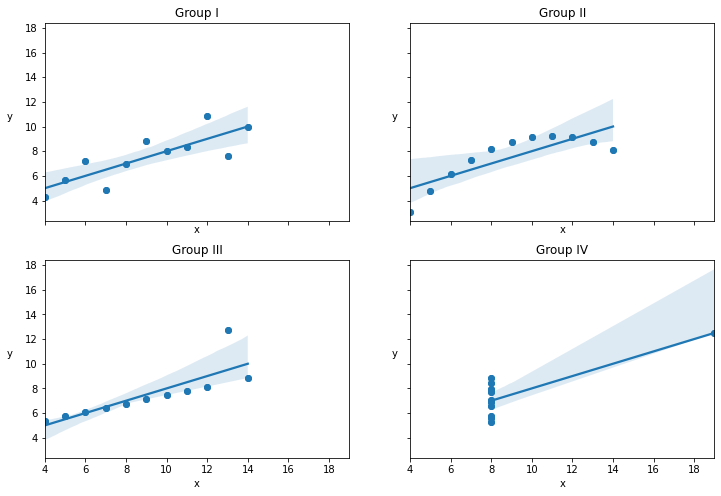

In [69]:
x_0 = df[df.dataset == 'I']['x'].values
y_0 = df[df.dataset == 'I']['y'].values
x_1 = df[df.dataset == 'II']['x'].values
y_1 = df[df.dataset == 'II']['y'].values
x_2 = df[df.dataset == 'III']['x'].values
y_2 = df[df.dataset == 'III']['y'].values
x_3 = df[df.dataset == 'IV']['x'].values
y_3 = df[df.dataset == 'IV']['y'].values
_, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


print("Mean of x values in all groups -- ",x_0.mean(), x_1.mean(), x_2.mean(), x_3.mean())
print("Mean of y values in all groups -- ",y_0.mean(), y_1.mean(), y_2.mean(), y_3.mean())
print("Mean of x values in all groups -- ",x_0.var(), x_1.var(), x_2.var(), x_3.var())
print("Mean of y values in all groups -- ",y_0.var(), y_1.var(), y_2.var(), y_3.var())

ax = np.ravel(ax)
ax[0].scatter(x_0, y_0)
sns.regplot(x_0, y_0, ax=ax[0])
ax[0].set_title('Group I')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0, labelpad=15)

ax[1].scatter(x_1, y_1)
sns.regplot(x_1, y_1, ax=ax[1])
ax[1].set_title('Group II')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y', rotation=0, labelpad=15)

ax[2].scatter(x_2, y_2)
sns.regplot(x_2, y_2, ax=ax[2])
ax[2].set_title('Group III')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y', rotation=0, labelpad=15)

ax[3].scatter(x_3, y_3)
sns.regplot(x_3, y_3, ax=ax[3])
ax[3].set_title('Group IV')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y', rotation=0, labelpad=15)

#### Plot Data Group 3 and its Kernel Density

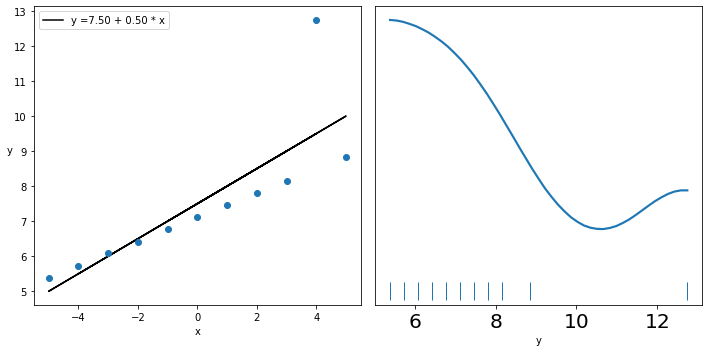

In [40]:
x_2 = x_2 - x_2.mean()
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_2, y_2)[:2]
ax[0].plot(x_2, (alpha_c + beta_c * x_2), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_2, y_2, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_2, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

#### Model using a Student's t Distribution

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:08<00:00, 1229.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


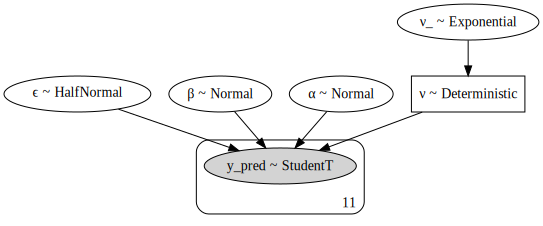

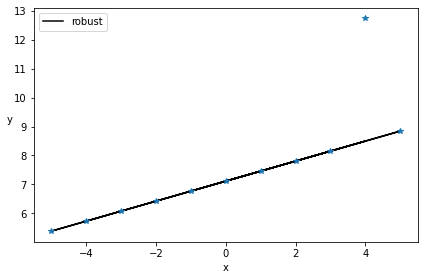

In [41]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1) # shifting the exponential to avoid values close to 0
    y_pred = pm.StudentT('y_pred', mu=α + β * x_2,
                         sd=ϵ, nu=ν, observed=y_2)
    trace_t = pm.sample(2000)
    
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_2, alpha_m + beta_m * x_2, c='k', label='robust')
plt.plot(x_2, y_2, '*')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

pm.model_to_graphviz(model_t)

### Hierarchical Linear Regression

We want to use the same hierarchical or multilevel modeling technique that we discussed earlier, for linear regression problems as well. As mentioned above, this is particularly useful when presented with imbalanced subgroups of sparse data. In this example, we create data with 8 subgroups. In this data, 7 of the subgroups have 20 data points and the last one has a single data point. 

The data for all the 8 groups are generated from a normal distribution of mean 10 and a standard deviation of 1. The parameters for the linear model are generated from the normal and beta distributions.

#### Data Generation

Alpha parameters  [4.16608544 4.78196448 4.85228509 3.29292904 3.06834281 4.88666088
 3.77821034 4.38172358]


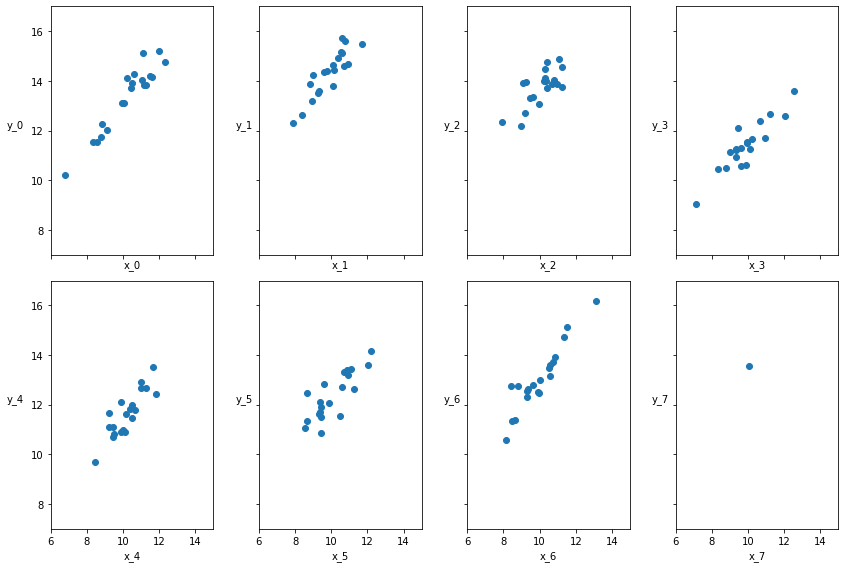

In [102]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

np.random.seed(314)
alpha_real = np.random.normal(4, 1, size=M) 
beta_real = np.random.beta(7, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
print("Alpha parameters ", alpha_real )

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(12,8), sharex=True, sharey=True)

ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)     
    j += N
    k += N
plt.tight_layout()

#### Non-hierarchical Model

We build a non-hierarchical model first for comparison. We also mean-center the data for ease of convergence. Note how the obtained $\alpha$ and $\beta$ values vary for each group, particularly the scale of the last one, which is really off.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:17<00:00, 584.40draws/s]


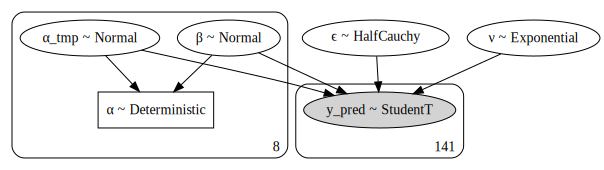

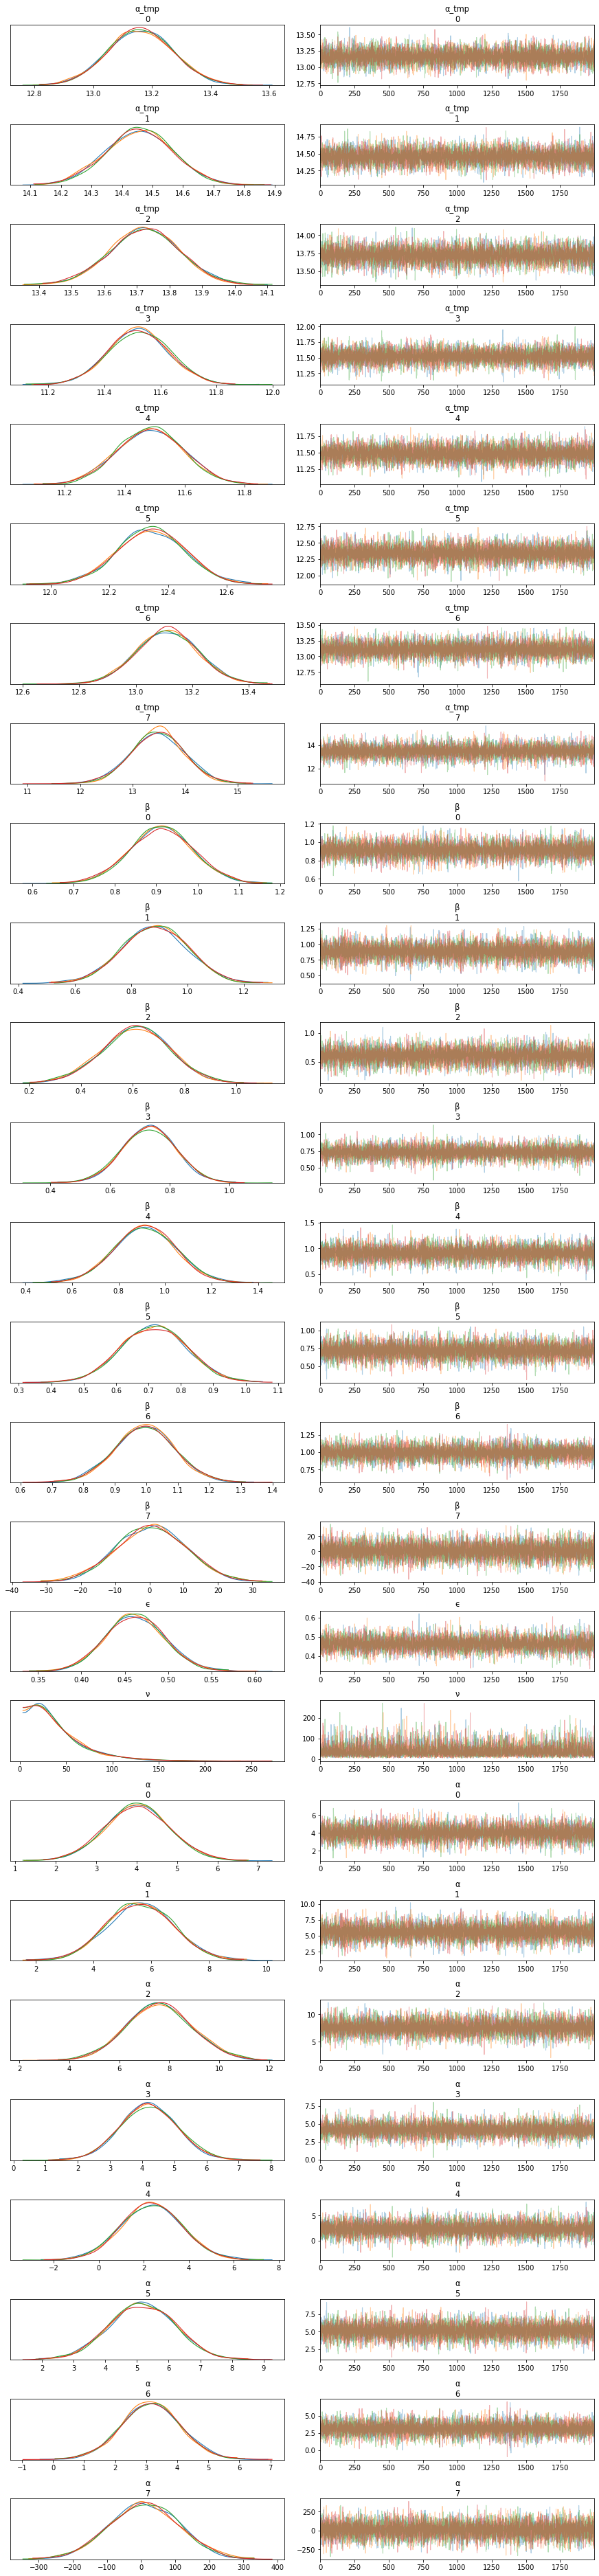

<Figure size 432x288 with 0 Axes>

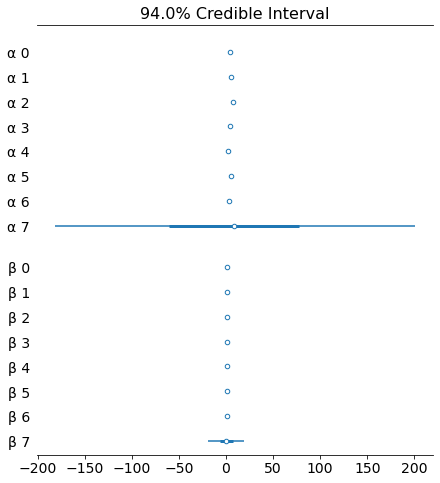

In [103]:
# Center the data
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    # Note the M prior parameters for the M groups
    α_tmp = pm.Normal('α_tmp', mu=2, sd=5, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
    # Rescale alpha back - after x had been centered the computed alpha is different from the original alpha
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    trace_up = pm.sample(2000)

az.plot_trace(trace_up)
plt.figure()
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)
az.summary(trace_up)

pm.model_to_graphviz(unpooled_model)

#### Hierarchical Model

We set hyperpriors on the \\(\alpha\\) and \\(\beta\\) parameters. To be more precise, the hyperpriors are applied to the scaled version of \\(\alpha\\), i.e. \\(\alpha_{tmp}\\).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 4 chains, 119 divergences: 100%|██████████| 6000/6000 [00:34<00:00, 173.77draws/s]
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9296457057021434, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9215539233466684, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9761114878843552, but should be close 

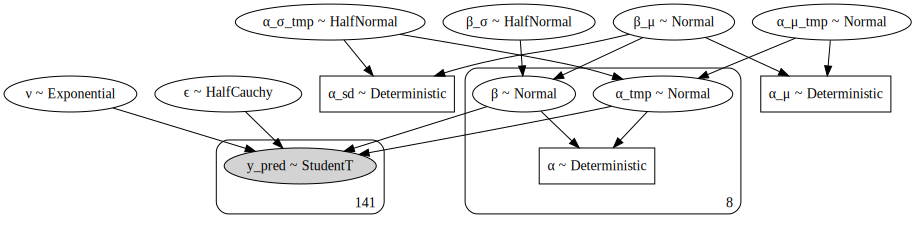

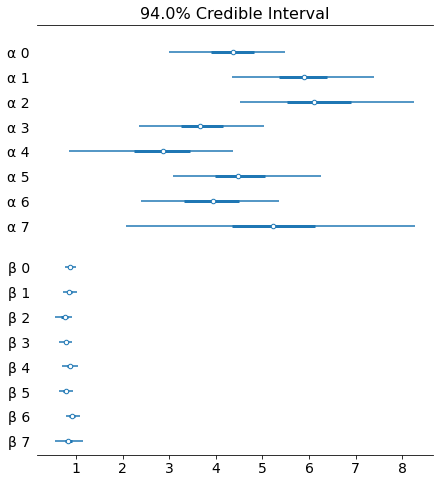

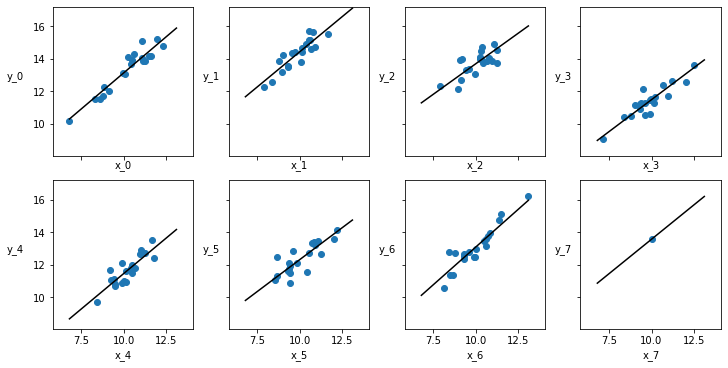

In [104]:
with pm.Model() as hierarchical_model:
    # Hyperpriors - we add these instead of setting the prior values to a constant
    # Note that there exists only one hyperprior  for all M groups, shared hyperprior
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=100, sd=1) # try changing these hyperparameters
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10) # try changing these hyperparameters
    β_μ = pm.Normal('β_μ', mu=10, sd=2) # reasonable changes do not have an impact
    β_σ = pm.HalfNormal('β_σ', sd=5)
    
    # priors - note that the prior parameters are no longer a constant
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred',
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ *
                           x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    trace_hm = pm.sample(1000)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

pm.model_to_graphviz(hierarchical_model)

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Polynomial Regression for Nonlinear Data

What happens when the data is inherently nonlinear? It is more appropriate to use non-linear combinations of the inputs. This could be in the form of higher order terms such as \\(x^2, x^3\\) or it could use basis functions such as the cosine function, \\(cos(x)\\).

#### Data Generation

Use the values from the dataset in Anscombe's quartet we used earlier as our non-linear data. We will use the regression model given by

$$ y = \alpha + \beta_1 * x_{centered} + \beta_2 * x_{centered}^2 $$

Text(0, 0.5, 'y')

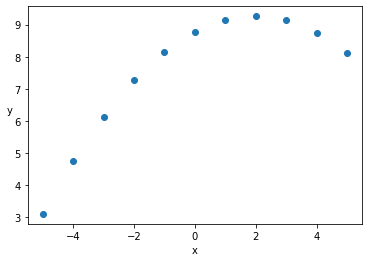

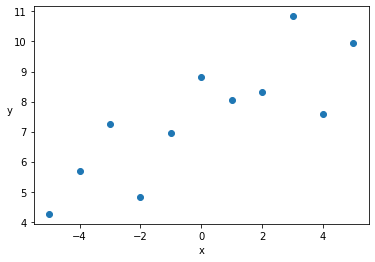

In [105]:
x_1_centered = x_1 - x_1.mean()
plt.scatter(x_1_centered, y_1)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

plt.figure()
x_0_centered = x_0 - x_0.mean()
plt.scatter(x_0_centered, y_0)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

#### Inference on Data I

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:08<00:00, 1779.71draws/s]


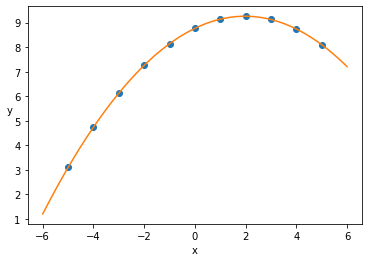

In [111]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_1.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_1_centered + β2 * x_1_centered**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_1)
    trace = pm.sample(2000, tune=2000)
    
x_p = np.linspace(-6, 6)
y_p = trace['α'].mean() + trace['β1'].mean() * x_p + trace['β2'].mean() * x_p**2
plt.scatter(x_1_centered, y_1)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')



#### Inference on Data II

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1669.11draws/s]


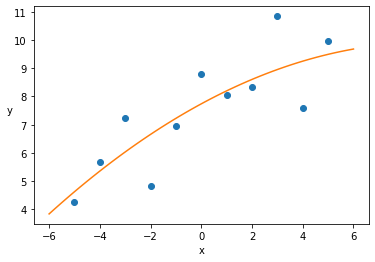

In [112]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_0.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_0_centered + β2 * x_0_centered**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_0)
    trace = pm.sample(2000)
    
x_p = np.linspace(-6, 6)
y_p = trace['α'].mean() + trace['β1'].mean() * x_p + trace['β2'].mean() * x_p**2
plt.scatter(x_0_centered, y_0)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Multiple Linear Regression

In Multiple Linear Regression, there is more than one independent variable to predict the outcome of one dependent variable.

$$ y = \alpha + \overrightarrow{\beta} \cdot \overrightarrow{X} $$

#### Data Generation

The example below generates two-dimensional data for X. It plots the variation of 'y' with each component of X in the top two figures. The bottom figure indicates the correlation of the two components of X.

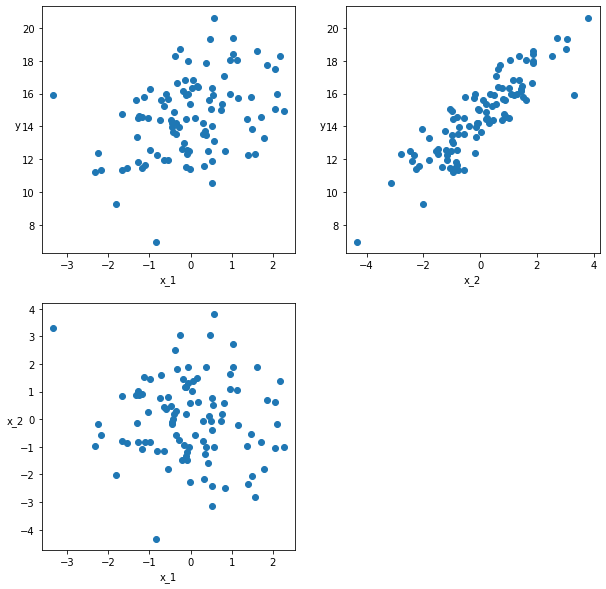

In [115]:
np.random.seed(314)

# N is the total number of observations 
N = 100
# m is 2, the number of independent variables
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

# X is # n x m
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T 
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)

#### Inference

This code is very similar to what we have already seen, the only real difference being the dimensionality of the coefficients and the inputs. Something you would notice is that as the number of unknowns increase, the uncertainty associated with our inferences become larger. It is beneficial to have more accurate priors in this situation.

In [125]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=2, sd=2) # Try changing the prior distribution
    β = pm.Normal('β', mu=0, sd=5, shape=2) # Note the shape of beta
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace = pm.sample(2000, tune=1000)
    
az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2090.64draws/s]


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
α_tmp  14.589  0.048  14.502   14.679      0.000    0.000   12793.0  12793.0   
β[0]    0.971  0.044   0.885    1.050      0.000    0.000   10265.0  10248.0   
β[1]    1.471  0.033   1.411    1.533      0.000    0.000   11240.0  11240.0   
ϵ       0.474  0.035   0.412    0.545      0.000    0.000   10134.0  10104.0   
α[0]    1.822  0.457   0.975    2.688      0.005    0.003   10166.0   9754.0   

       ess_bulk  ess_tail  r_hat  
α_tmp   12773.0    6290.0    1.0  
β[0]    10282.0    6003.0    1.0  
β[1]    11270.0    5879.0    1.0  
ϵ       10083.0    6060.0    1.0  
α[0]    10210.0    6202.0    1.0

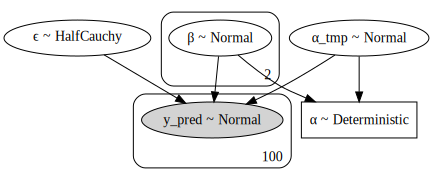

In [126]:
pm.model_to_graphviz(model_mlr)

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Logistic Regression

While everything we have seen so far involved regression, the same ideas can be applied to a classification task as well. We use the logistic regression model to perform this classification here. The name 'regression' is due to the fact that the model outputs class probabilities as numbers which is then converted into classes using a decision boundary. There are many ways to select an appropriate decision boundary, a few of which were covered in Course 1 and Course 2.

#### Inverse Link function

At this point it is a good idea to bring up the concept of a inverse link function, which takes the form

$\theta = f(\alpha + \beta x)$

Here 'f' is called the inverse link function, the term inverse refers to the fact that the function is applied to the right hand side of the equation. In a linear regression, this inverse link function is the identity function. In the case of a linear regression model, the value 'y' at any point 'x' is modeled as the mean of a Gaussian distribution centered at the point (x,y). The error as a result of the true 'y' and the estimated 'y' are modeled with the standard deviation of this Gaussian at that point (x,y). Now think about the scenario where this is not appropriately modeled using a Gaussian. A classification problem is a perfect example of such a scenario where the discrete classes are not modeled well as a Gaussian and hence we can't use this distribution to model the mean of those classes. As a result, we would like to convert the output of $\alpha + \beta x$ to some other range of values that are more appropriate to the problem being modeled, which is what the link function intends to do.

#### Logistic function

The logistic function is defined as the function

$logistic(x) = \dfrac{1}{1 + \exp{(-x)}}$

This is also called the sigmoid function and it restricts the value of the output to the range [0,1].

Text(0, 0.5, 'logistic(x)')

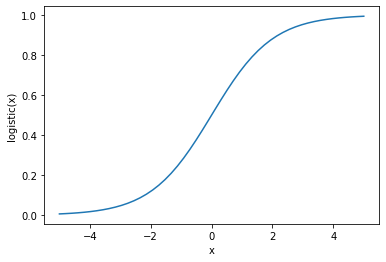

In [127]:
x = np.linspace(-5,5)
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.xlabel('x')
plt.ylabel('logistic(x)')


#### Example using the Iris data

The simplest example using a logistic regression model is one that can be used to identify two classes. If you are given a set of independent variables that are features which correspond to an output dependent variable that is a class, you can build a model to learn the relationship between the features and the output classes. This is done with the help of the logistic function which acts as the inverse link function to relate the features to the output class. 

$\theta = logistic(\alpha + \beta x)$

If it is a two-class problem (binary classification), the output variable can be represented by a Bernoulli distribution.

$y \sim Bern(\theta)$

The mean parameter $\theta$ is now given by the regression equation $logistic(\alpha + \beta x)$. In regular linear regression, this parameter was drawn from a Gaussian distribution. In the case of the coin-flip example the data likelihood was represented by a Bernoulli distribution, (the parameter $\theta$ was drawn from a Beta prior distribution there), similarly we have output classes associated with every observation here.

We load the iris data from scikit learn and

* Plot the distribution of the three classes for two of the features. 

* We also perform a pairplot to visualize the correlation of each feature with every other feature. The diagonal of this plot shows the distribution of the three classes for that feature.

* Correlation plot of just the features. This can be visually cleaner and cognitively simpler to comprehend.

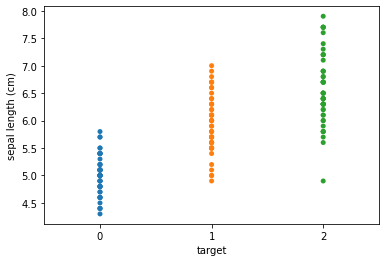

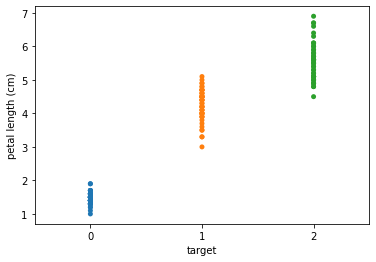

<Figure size 432x288 with 0 Axes>

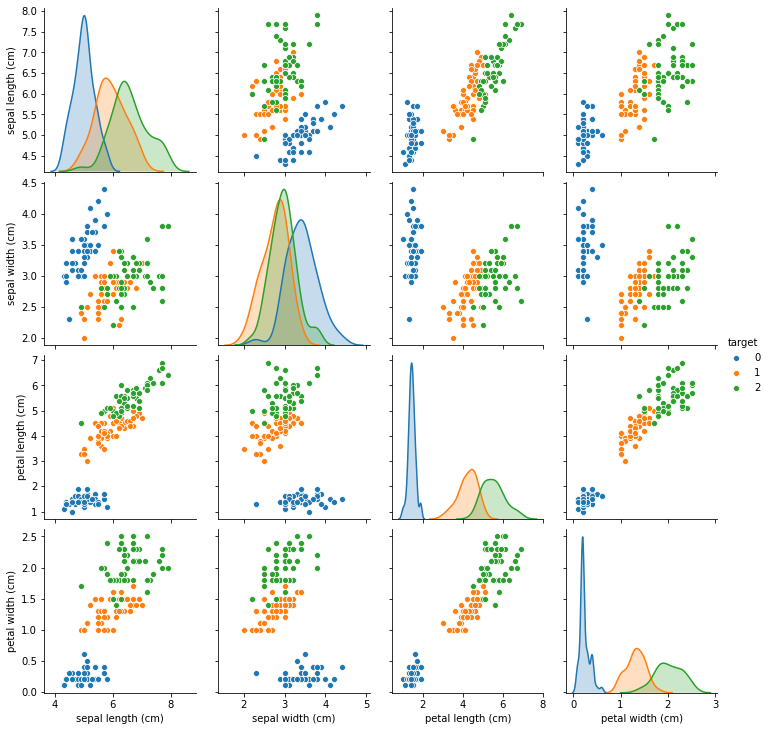

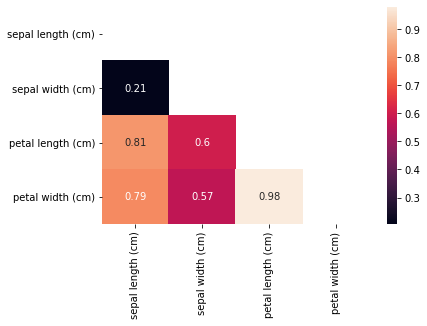

In [129]:
import pymc3 as pm
import sklearn
import numpy as np
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn import datasets
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']
seaborn.stripplot(x='target', y='sepal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.stripplot(x='target', y='petal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.pairplot(iris_data, hue='target', diag_kind='kde')
plt.figure()
corr = iris_data.query("target == (0,1)").loc[:, iris_data.columns != 'target'].corr() 
mask = np.tri(*corr.shape).T 
seaborn.heatmap(corr.abs(), mask=mask, annot=True)
plt.show()

You would notice that some of the variables have a high degree of correlation from the correlation plot. One approach is to eliminate one of the correlated variables. The second option is to mean-center and use a weakly-informative prior such as a Students t-distribution for all variables that are not binary. The scale parameter can be adjusted for the range of expected values for these variables and the normality parameter is recommended to be between 3 and 7. (Source: Andrew Gelman and the Stan team)



In [5]:
df['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

#### Inference

We use a **single feature**, the sepal length, to learn a decision boundary between the **first two classes** in the iris data (0,1).

In this case, the decision boundary is defined to be the value of 'x' when 'y' = 0.5. We won't go over the derivation here, but this turns out to be \\(-\alpha / \beta\\). However, this value was chosen under the assumption that the midpoint of the class values are a good candidate for separating the classes, but this does not have to be the case.

In [130]:
# Select the first two classes for a binary classification problem
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = 'sepal length (cm)' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1717.46draws/s]


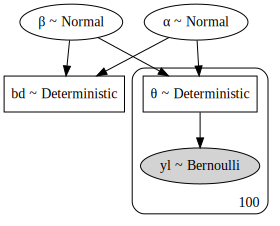

In [131]:
import pymc3 as pm
import arviz as az

with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    trace_0 = pm.sample(1000)

pm.model_to_graphviz(model_0)

In [132]:
az.summary(trace_0, var_names=["α","β","bd"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α   0.313  0.338  -0.295    0.977      0.006    0.005    2840.0  2158.0   
β   5.401  1.044   3.501    7.359      0.019    0.014    3048.0  2843.0   
bd -0.057  0.062  -0.176    0.054      0.001    0.001    2901.0  2425.0   

    ess_bulk  ess_tail  r_hat  
α     2851.0    2198.0    1.0  
β     3131.0    2400.0    1.0  
bd    2915.0    2303.0    1.0

#### Visualizing the Decision Boundary

* The classifier outputs, i.e. the y values are jittered to make it easier to visualize. 
* The solid green lines are the mean of the fitted \\(\theta\\) as a result of the sampling and inference process
* The transparent green lines indicate the 94% HPD (default values) for the fitted \\(\theta\\).
* The solid blue line indicates the decision boundary that is derived from the inferred values of the parameters using the equation \\(\alpha/\beta\\)
* The transparent blue indicates the HPD (94%) for the decision boundary.

([<matplotlib.axis.XTick at 0x7fc2e8ccf9a0>,
 [Text(0, 0, '4.0'),
  Text(0, 0, '4.5'),
  Text(0, 0, '5.0'),
  Text(0, 0, '5.5'),
  Text(0, 0, '6.0'),
  Text(0, 0, '6.5'),
  Text(0, 0, '7.0'),
  Text(0, 0, '7.5')])

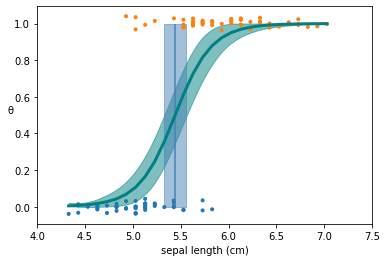

In [144]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)

# Plot the fitted theta
plt.plot(x_c[idx], theta[idx], color='teal', lw=3)
# Plot the HPD for the fitted theta
az.plot_hpd(x_c, trace_0['θ'], color='teal')
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)

# Plot the decision boundary
plt.vlines(trace_0['bd'].mean(), 0, 1, color='steelblue')
# Plot the HPD for the decision boundary
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='steelblue', alpha=0.5)
plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])

# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

#### Multiple Logistic Regression

The above example with a single feature can be extended to take **multiple features** or independent variables to separate the same **two classes**.

In [145]:
# Select the first two classes for a binary classification problem
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = ['sepal length (cm)', 'sepal width (cm)']
# Center the data by subtracting the mean from both columns
df_c = df - df.mean() 
x_c = df_c[x_n].values


As we saw before, the equation for multiple logistic regression relating the $\theta$ parameter to the features can be written as 

$$\theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2)$$

$$y \sim Bern(\theta)$$

This gives us a decision boundary, assuming y = 0.5 is a reasonable boundary, of 

$$x_2 = -\dfrac{\alpha}{\beta_2} - \dfrac{\beta_1}{\beta_2} x_1$$

Unlike the previous equation, this one represents a line for the variables \\(x_1\\) and \\(x_2\\) which separates the two-dimensional space occupied by \\(x_1\\) and \\(x_2\\). For higher dimensions, this decision boundary will be a hyperplane of dimension 'n-1' for a feature space of dimension 'n'.

#### Inference

In [146]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
    μ = α + pm.math.dot(x_c, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_c[:,0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_0) 
    trace_0 = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:04<00:00, 2132.03draws/s]


#### Visualization

We plot the HPD on the centered data, we have not scaled it back to the original range here.

Text(0, 0.5, 'sepal width (cm)')

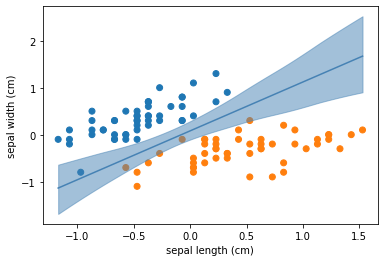

In [148]:
idx = np.argsort(x_c[:,0]) 
bd = trace_0['bd'].mean(0)[idx] 
plt.scatter(x_c[:,0], x_c[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_c[:,0][idx], bd, color='steelblue'); 
az.plot_hpd(x_c[:,0], trace_0['bd'], color='steelblue')
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

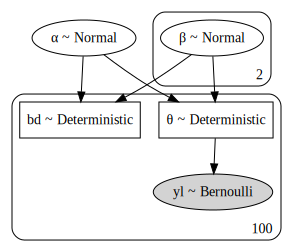

In [149]:
pm.model_to_graphviz(model_1)

### Multiclass Classification

If we have more than two classes this becomes a multiclass problem. In this case we use the softmax function instead of the sigmoid function. The sigmoid function is a special case of the softmax for a two-class classification problem. The softmax function can be written as

$$ softmax(x_i) = \dfrac{\exp(x_i)}{\sum_k \exp(x_k)} $$

Earlier, we also used a Bernoulli distribution as the likelihood for our $\theta$ parameter, however now we sample from a categorical distribution.

$$\theta = softmax(\alpha + \beta x)$$

$$y \sim Categorical(\theta)$$

#### Logistic Regression for a Multiclass Problem 

We reuse the previous example, however we are going to use all the three classes in the data here along with all the features for maximum separability. The data is also standardized instead of just mean-centered here.


In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import pymc3 as pm
import numpy as np
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']
y_s = iris_data.target
x_n = iris_data.columns[:-1]
x_s = iris_data[x_n]
x_s = (x_s - x_s.mean()) / x_s.std()
x_s = x_s.values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 75 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


'0.98'

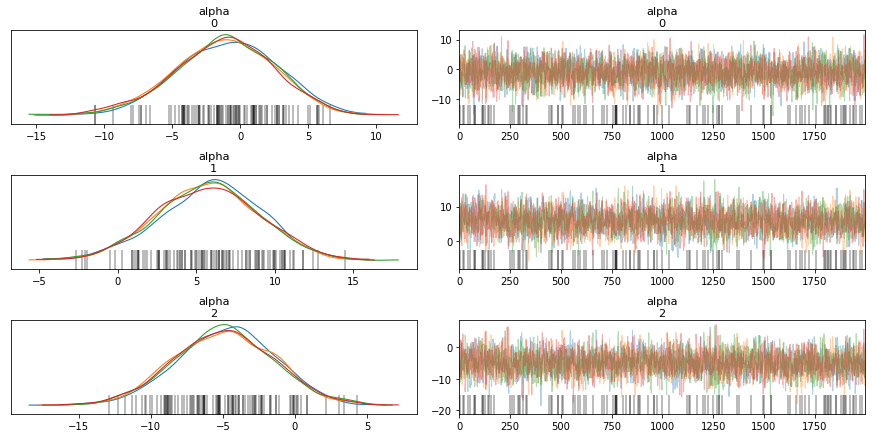

In [5]:
import theano as tt
tt.config.gcc.cxxflags = "-Wno-c++11-narrowing"

with pm.Model() as model_mclass:
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=3)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', alpha + pm.math.dot(x_s, beta))
    θ = tt.tensor.nnet.softmax(μ)
    #θ = pm.math.exp(μ)/pm.math.sum(pm.math.exp(μ), axis=0)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]
az.plot_trace(trace_s, var_names=['alpha'])
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'


<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Inferring Rate Change with a Poisson Distribution

Discrete variables that represents count data can be handled using a Poisson distribution. The key element here is that it is the number of events happening in a given interval of time. The events are supposed to be independent and   the distribution is parameterized using a single value called the rate parameter. This corresponds to and controls both the mean and the variance of the distribution. One implication of this is that the higher the mean, the larger the variance of the distribution which can be a limitation for some phenomena. A higher value of the rate parameter indicates a higher likelihood of getting larger values from our distribution. It is represented by

$f(x) = e^{-\mu} \mu^x / x!$

* The mean rate is represented by $\mu$
* x is a positive integer that represents the number of events that can happen

If you recall from the discussion of the binomial distribution, that can also be used to model the probability of the number of successes out of 'n' trials. The Poisson distribution is a special case of this binomial distribution and is used when the trials far exceed the number of successes. 

#### Poisson Distribution Example

In the following example we look at a time-varying rate phenomena, consider the observations as the number of COVID-19 cases per day. We observe cases for 140 days, however due to some interventional measures put in place it is suspected that the number of cases per day have gone down. If we assume that the number of cases can be modeled using a Poisson distribution, then this implies that there are two rates $\lambda_1$ and $\lambda_2$, and we can try to find where this rate-switch happens (time $\tau$). 

We don't really know a lot about these rates, so we select a prior for both which can be from an Exponential, Gamma or Uniform distributions. Both the Exponential and Gamma distributions work better than the Uniform distribution since the Uniform distribution is the least informative. As usual, with enough observations one can even get away with a Uniform prior. Since we have no information regarding $\tau$, we select a Uniform prior distribution for that.

In the example below, try varying the following

1. Types of priors - a more informed prior is always better if this information is available
2. The size of the data or the observations and the value of the theta parameter - more data results in better inference overall, the larger the difference in theta the easier to determine these rates
3. The number of drawn samples - better and more accurate inference
4. The number of chains - should reduce variance
5. The number of cores - cores should be no more than the total number of chains and should be limited to the total number of cores on your hardware, you should see an increase in speed or decrease in runtime as you increase the number of cores.

Note that this uses the Metropolis algorithm since this is a discrete sampling problem.

Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 10 chains for 1_000 tune and 5_000 draw iterations (10_000 + 50_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'lambda_1'}>,
        <AxesSubplot:title={'center':'lambda_1'}>],
       [<AxesSubplot:title={'center':'lambda_2'}>,
        <AxesSubplot:title={'center':'lambda_2'}>]], dtype=object)

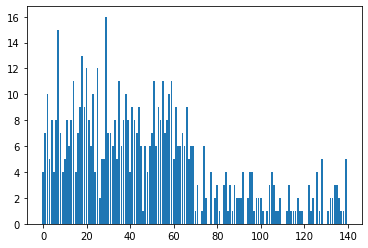

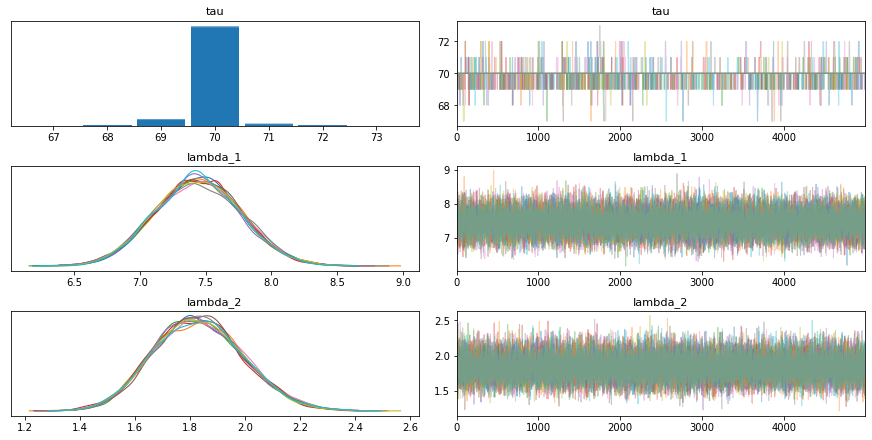

In [9]:
# ------------ Create the data ---------- #
n_1 = 70
θ_real_1 = 7.5
#ψ = 0.1
 # Simulate some data
counts_1 = np.random.poisson(θ_real_1,n_1)
#plt.bar(np.arange(len(counts_1)),counts_1)

n_2 = 70
θ_real_2 = 2.0
#ψ = 0.1
 # Simulate some data
counts_2 = np.random.poisson(θ_real_2,n_2)
#plt.bar(np.arange(len(counts_2)),counts_2)

total_data = np.concatenate((counts_1, counts_2))
n_counts = len(counts_1) + len(counts_2)
plt.figure()
plt.bar(np.arange(len(total_data)),total_data)

# ------------ Generate the model ----------- #

with pm.Model() as model_poisson:

    alpha_1 = 1.0 / counts_1.mean()
    alpha_2 = 1.0 / counts_2.mean()

    # Different priors have different results                     
    lambda_1 = pm.Exponential("lambda_1", alpha_1)
    lambda_2 = pm.Exponential("lambda_2", alpha_2) 
    #lambda_1 = pm.Gamma("lambda_1", 2, 0.1)
    #lambda_2 = pm.Gamma("lambda_2", 2, 0.1)
    #lambda_1 = pm.Uniform("lambda_1",lower=0, upper=5)
    
    # Uniform prior for the day since we have no information, if we do we should modify the prior to         
    # incorporate that information
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_counts - 1)
    idx = np.arange(n_counts) # id for the day
    lambda_c = pm.math.switch(tau > idx, lambda_1, lambda_2) # switch rate depending on the tau drawn

    observation = pm.Poisson("obs", lambda_c, observed=total_data)
    trace = pm.sample(5000, chains=10, cores=4)

az.plot_trace(trace)

#### Visualize \\(\tau\\)

We can use the ECDF (Empirical Cumulative Distribution Function) to visualize the distribution of \\(\tau\\). The ECDF helps to visualize the distribution by plotting the CDF as opposed to the binning techniques used by a histogram. It also helps us to identify what values in the data are beneath a certain probability.

A reasonable scenario looks like the following:

1. Starting from day 1 till day 'd', it is expected that the rate parameter will be \\(\lambda_1\\), i.e with probability 100%. 
2. On day 'd', it is possible that the rate is \\(\lambda_1\\) with probability 'x' which implies that the rate could be \\(\lambda_2\\) with probability '1 - x'. So this means that  the distribution of \\(\tau\\) has some probability mass on day 'd' indicating that the rate parameter switches to \\(\lambda_2\\) on this day. 
3. For days after day 'd', the rate is \\(\lambda_2\\) with probability 100%.

Tau is  [70 70 70 ... 70 70 70]
Length of tau 50000
Lambda 1 is  [7.69250846 7.19839796 7.10817603 ... 6.85540056 6.94550251 8.0374546 ]
Length of Lambda 1  50000


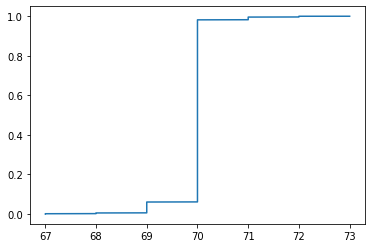

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF
print('Tau is ',trace['tau'])
print("Length of tau", len(trace['tau']))
print('Lambda 1 is ',trace['lambda_1'])
print("Length of Lambda 1 ",len(trace['lambda_1']))
ecdf = ECDF(trace['tau'])
plt.plot(ecdf.x, ecdf.y, '-')

In [12]:
for elem in idx:
    prob_lambda_2 = ecdf([elem])
    prob_lambda_1 = 1.0 - prob_lambda_2
    print("Day %d, the probability of rate being lambda_1 is %lf and lambda_2 is %lf "%(elem, prob_lambda_1, prob_lambda_2))

Day 0, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 1, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 2, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 3, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 4, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 5, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 6, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 7, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 8, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 9, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 10, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 0.000000 
Day 11, the probability of rate being lambda_1 is 1.000000 and lambda_2 is 

#### Expected Value of Cases

For each draw of $\tau$, there is a draw of $\lambda_1$ and $\lambda_2$. We can use the principles of Monte Carlo approximation to compute the expected value of COVID-19 cases on any day. 

Expected value for day = $ \dfrac{1}{N} \sum_{0}^{nsamples}$ Lambda_draw ;  day > Tau_draw ? lambda_2_draw : lambda_1_draw

* Draws are in combinations of \\((\lambda_1, \lambda_2, \tau)\\), we want to average out the \\(\lambda\\) value based on the proportion of \\(\lambda\\) suggestions as indicated by the samples

* For days 0,...68 we see that the probability of \\(\lambda_1\\) is 1 whereas the probability of \\(\lambda_2\\) is 0. So the expected value is just the average of all the \\(\lambda_1\\) samples.

* Similarly, for days from 72,... the probability of \\(\lambda_2\\) is 1 and the probability of \\(\lambda_1\\) is 0. So the expected value of \\(\lambda\\) is just the average of all the \\(\lambda_2\\) samples.

* For days in between - let us assume for day 69, we have 10% of the samples indicating that \\(\tau\\) is 70 while 90% indicate that \\(\tau\\) is 69. 

 * If \\(\tau\\) is 70, that means that day 69 has rate \\(\lambda_1\\) but if \\(\tau\\) is 69 that implies that day 69 has rate \\(\lambda_2\\). 
       
 * The contribution to the expected value will 10% coming from sum(lambda_1_samples_that_have_tau_70) and 90% coming sum(lambda_2_samples_that_have_tau_69)
              

In [34]:
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

1.9741810401030493
7.421339061365563


In [31]:
tau_samples = trace['tau']
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']

N = tau_samples.shape[0]
expected_values = np.zeros(n_counts)
for day in range(0, n_counts):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # For each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    expected_values[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

expected_values

array([1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97418104, 1.97418104, 1.97418104, 1.97418104, 1.97418104,
       1.97446319, 1.97446319, 1.97576911, 1.98390101, 2.32024244,
       7.30613614, 7.42059683, 7.42133906, 7.42133906, 7.42133

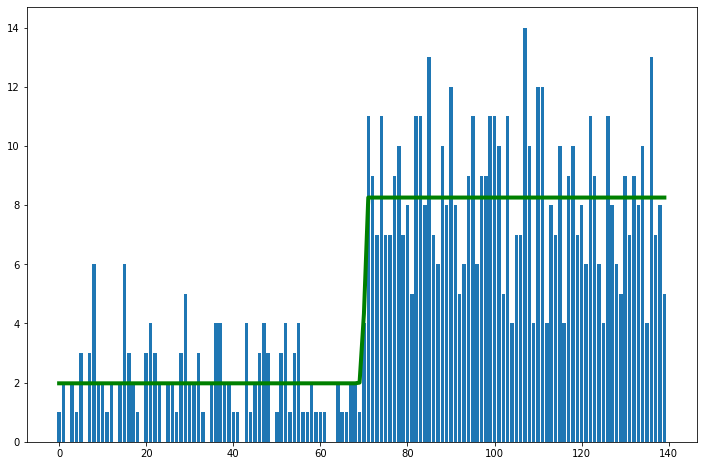

In [24]:
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(total_data)),total_data)
plt.plot(np.arange(n_counts), expected_values, color='g', lw='4')

### GRADED EVALUATION (30 mins)

1. Mean-centering the data helps MCMC Sampling by

    a. Reducing the correlation between the variables (C)
    
    b. Reducing the variance of the variables 
    
    
2. Hierarchical Linear Regression is beneficial when pooling data results in vital group information being lost

    a. True (C)
    
    b. False 
    
    
3. Does this code indicate a 

    a. Hierarchical model
    
    b. Non-hierarchical model (C)
    

```
    α_tmp = pm.Normal('α_tmp', mu=2, sd=5, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)
   
```

    
  
4. Non-hierarchical Linear Regression with groups of sparse data can result in

    a. very large credible intervals (C)
    
    b. very small credible intervals
    

5. In Hierarchical Linear Regression, priors (not hyperpriors) on variable distributions 

    a. are constant values
    
    b. distributions
    
    
6. Polynomial Regression is useful for

    a. Linear data
    
    b. Non-linear data
    
    
7. Multiple Linear Regression is used when you have

    a. Multiple dependent or target variables
    
    b. Multiple independent or predictor variables (C)
    
    
8. PyMC3 allows you to model multiple predictor variables uing the shape parameter in a distribution without having to create multiple parameters explicitly

    a. True (C)
    
    b. False
    

9. The inverse link function of linear regression is

    a. Logit function
    
    b. Identity function (C)
   
   
10. Multiclass classification uses the

    a. Sigmoid function 
    
    b. Softmax function (C)
    
    
11. A binary classification problem uses the Bernoulli distribution to model the target, the multiclass classification uses

    a. Categorical distribution (C)
    
    b. Poisson distribution

<br>
<br>
<hr style="border:2px solid blue"> </hr>


### MCMC Metrics

#### Paper discussing Bayesian visualization

https://arxiv.org/pdf/1709.01449.pdf

#### Tuning

[Colin Caroll's talk](https://colcarroll.github.io/hmc_tuning_talk/)

When a step size is required, PyMC3 uses the first 500 steps varying the step size to get to an acceptance rate of 23.4%. 

* The acceptance rate is the proportion of proposed values that are not rejected during the sampling process. Refer to Course 2, Metropolis Algorithms for more information. 

* In Metropolis algorithms, the step size is related to the variance of the proposal distribution. See the next section for more information.

These are the default numbers that PyMC3 uses, which can be modified. It was reported in a study that the acceptance rate of 23.4% results in the highest efficiency for Metropolis Hastings. These are empirical results and therefore should be treated as guidelines. According to the SAS Institute, a high acceptance rate (90% or so) usually is a sign that the new samples are being drawn from points close to the existing point and therefore the sampler is not exploring the space much. On the other hand, a low acceptance rate is probably due to inappropriate proposal distribution causing new samples to be rejected. PyMC3 aims to get an acceptance rate between 20% and 50% for Metropolis Hastings, 65% for Hamiltonian Monte Carlo (HMC) and 85% for No U-Turn Sampler (NUTS)

If you have convergence issues as indicated by the visual inspection of the trace, you can try increasing the number of samples used for tuning. It is also worth pointing out that there is more than just step-size adaptation that is happening during this tuning phase. 

`pm.sample(num_samples, n_tune=num_tuning)`

##### Metropolis algorithm
In the Metropolis algorithm the standard deviation of the proposal distribution is a tuning parameter that can be set while initializing the algorithm. 

$x_{t+1} \sim Normal(x_t, stepsize \cdot I)$

The larger this value, the larger the space from where new samples can be drawn. If the acceptance rate is too high, increase this standard deviation. Keep in mind that you run the risk of getting invalid draws if it is too large. 

##### Hamiltonian Monte Carlo (HMC) algorithm

The HMC algorithm is based on the solution of differential equations known as Hamilton's equations. These differential equations depend on the probability distributions we are trying to learn. We navigate these distributions by moving around them in a trajectory using steps that are defined by a position and momentum at that position. Navigating these trajectories can be a very expensive process and the goal is to minimize this computational effort in this process.

To get a sense of the intuition behind HMC, it is based on the notion of conservation of energy. When the sampler trajectory is far away from the probability mass center, it has high potential energy but low kinetic energy and when it is closer to the center of the probability mass, it will have high kinetic energy but low potential energy.

The step size, in HMC, corresponds to the covariance of the momentum distribution that is sampled. Smaller step sizes move slowly in the manifold, however larger step sizes can result in integration errors. There is a Metropolis step at the end of the HMC algorithm and the  target acceptance rates of 65% in PyMC3 corresponds to this Metropolis step.

#### Mixing 

Mixing refers to how well the sampler covers the 'support' of the posterior distribution or rather how well it covers the entire distribution. Poor convergence is often a result of poor mixing. This can happen due to the choice of 

1. The choice of an inappropriate proposal distribution for Metropolis 
2. If we have too many correlated variables

The underlying cause for this can be

1. Too large a step size
2. Not running the sampler long enough
3. Multimodal distributions 


#### Rhat

We can compute a metric called Rhat (also called the potential scale reduction factor) that measures the ratio of the variance between the chains to the variance within the chains. It is calculated as the ratio of the standard deviation using the samples from all the chains (all samples appended together from each chain) over the  RMS of the within-chain standard deviations of all the chains. Poorly mixed samples will have greater variance in the accumulated samples (numerator) compared to the variance in the individual chains. It was empirically determined that Rhat values below 1.1 are considered acceptable while those above it are indications of a lack of convergence in the chains. Gelman et al. (2013) introduced a split Rhat that compares the first half with the second half of the samples from each chain to improve upon the regular Rhat. Arviz implements a split Rhat as can be seen from [Arviz Rhat](https://arviz-devs.github.io/arviz/generated/arviz.rhat.html). There is also an improved rank-based Rhat
[Improved Rhat](https://arxiv.org/pdf/1903.08008.pdf).

`az.rhat(trace, method='split')`

### Centered vs. Non-centered Parameterization

[T Wiecki on Reparametrization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)

When there is insufficient data in a hierarchical model, the variables being inferred end up having correlation effects, thereby making it difficult to sample. One obvious solution is to obtain more data, but when this isn't possible we resort to reparameterization by creating a non-centered model from the centered model.

#### Centered Model

$$ \mu \sim Normal (0,1)$$

$$ \sigma \sim HalfNormal(1)$$

$$y_i \sim Normal(\mu, \sigma)$$

And we try to fit the two parameters for $\mu$ and $\sigma$ directly here.

#### Non-centered Model


$$ \mu \sim Normal (0,1)$$

$$ \sigma \sim HalfNormal(1)$$

$$y_{i\_unit} \sim Normal(0,1)$$

$$y = \mu + \sigma y_{i\_unit}$$



/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [y, sigma, mu]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 16 seconds.
There were 2027 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6613714331625662, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1543 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7064652733253344, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3741 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5066897639865938, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some p

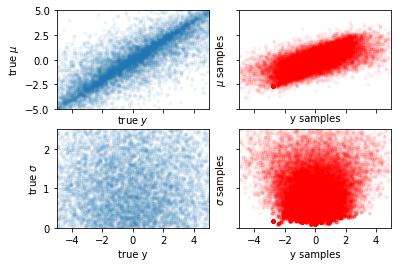

/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [yt, sigma, mu]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 14 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.


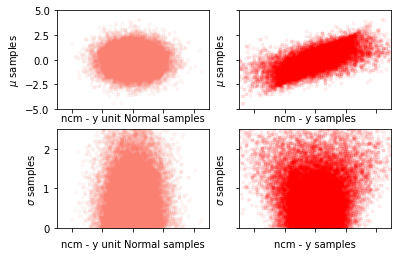

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import norm, halfcauchy, halfnorm


def centered_model():

    # generate data
    np.random.seed(0)
    n = 1
    m = 10000
    mu = norm.rvs(0, 3, m)
    sigma = halfnorm.rvs(0, 2, m)
    y = norm.rvs(mu, sigma, (n, m))

    # set up model
    with pm.Model():

        mu_ = pm.Normal("mu", 0, 1)
        sigma_ = pm.HalfNormal("sigma", 1)
        y_ = pm.Normal("y", mu_, sigma_, shape=n)

        # sample and save samples
        trace = pm.sample(m, chains=3)
        mu_samples = trace["mu"][:]
        sigma_samples = trace["sigma"][:]
        y_samples = trace["y"].T[:]
        
    sc = 5
    fig, axes = plt.subplots(2, 2, constrained_layout=False, sharex=True)
    ax = axes[0, 0]
    ax.scatter(y[0], mu, marker=".", alpha=0.05, rasterized=True)
    ax.set_xlim(-sc, sc)
    ax.set_ylim(-sc, sc)
    ax.set_ylabel("true $\mu$")
    ax.set_xlabel("true $y$")

    ax = axes[0, 1]
    ax.scatter(y_samples[0], mu_samples, marker=".", alpha=0.05, rasterized=True, color="r")
    ax.set_ylim(-sc, sc)
    ax.set_xlim(-sc, sc)
    ax.set_yticklabels([])
    ax.set_ylabel("$\mu$ samples")
    ax.set_xlabel("y samples")

    ax = axes[1, 0]
    ax.scatter(y[0], sigma, marker=".", alpha=0.05, rasterized=True)
    ax.set_ylim(0, sc / 2)
    ax.set_ylabel("true $\sigma$")
    ax.set_xlabel("true y")
    
    ax = axes[1, 1]
    ax.scatter(y_samples[0], sigma_samples, marker=".", alpha=0.05, rasterized=True, color="r")
    ax.set_ylim(0, sc / 2)
    ax.set_yticklabels([])
    ax.set_ylabel("$\sigma$ samples")
    ax.set_xlabel("y samples")

    plt.show()
    return(trace)
    

    
def noncentered_model():

    # generate data
    np.random.seed(0)
    n = 1
    m = 10000
    mu = norm.rvs(0, 3, m)
    sigma = halfnorm.rvs(0, 2, m)
    y = norm.rvs(mu, sigma, (n, m))

    # set up model
    with pm.Model():

        mu_ = pm.Normal("mu", 0, 1)
        sigma_ = pm.HalfNormal("sigma", 1)
        yt_ = pm.Normal("yt", 0, 1, shape=n)
        pm.Deterministic("y", mu_ + yt_ * sigma_)
        # y_ = pm.Normal("y", mu_, sigma_, shape=n)

        # sample and save samples
        trace = pm.sample(m, chains=3)
        mu_samples = trace["mu"][:]
        sigma_samples = trace["sigma"][:]
        yt_samples = trace["yt"].T[:]
        y_samples = trace["y"].T[:]

    # plot 2-D figures
    sc = 5
    fig, axes = plt.subplots(2, 2, constrained_layout=False, sharex=True)
    
    ax = axes[0, 0]
    ax.scatter(yt_samples[0], mu_samples, marker=".", alpha=0.05, rasterized=True, color="salmon")
    ax.set_xlim(-sc, sc)
    ax.set_ylim(-sc, sc)
    ax.set_ylabel("$\mu$ samples")
    ax.set_xlabel("ncm - y unit Normal samples")
    ax.set_xticklabels([])

    ax = axes[0, 1]
    ax.scatter(y_samples[0], mu_samples, marker=".", alpha=0.05, rasterized=True, color="r")
    ax.set_xlim(-sc, sc)
    ax.set_ylim(-sc, sc)
    ax.set_ylabel("$\mu$ samples")
    ax.set_xlabel("ncm - y samples")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax = axes[1, 0]
    ax.scatter(yt_samples[0], sigma_samples, marker=".", alpha=0.05, rasterized=True, color="salmon")
    ax.set_xlim(-sc, sc)
    ax.set_ylim(0, sc / 2)
    ax.set_xlabel("ncm - y unit Normal samples")
    ax.set_ylabel("$\sigma$ samples")

    ax = axes[1, 1]
    ax.scatter(y_samples[0], sigma_samples, marker=".", alpha=0.05, rasterized=True, color="r")
    ax.set_xlim(-sc, sc)
    ax.set_ylim(0, sc / 2)
    ax.set_yticklabels([])
    ax.set_xlabel("ncm - y samples")
    ax.set_ylabel("$\sigma$ samples")
    
    plt.show()
    return(trace)


trace_cm = centered_model()
trace_ncm = noncentered_model()

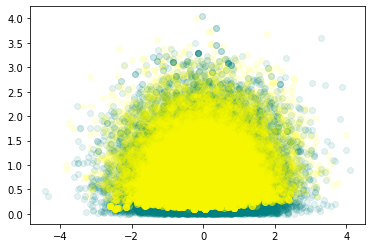

In [2]:
plt.figure()
plt.scatter(trace_ncm['mu'], trace_ncm['sigma'],c='teal', alpha=0.1)
plt.scatter(trace_cm['mu'], trace_cm['sigma'], c='yellow', alpha=0.1)
plt.show()

#### Convergence

------------ Centered model ------------


/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu    -0.095  0.970  -1.865    1.820      0.042    0.030     535.0   535.0   
y[0]  -0.109  1.406  -2.795    2.447      0.046    0.033     931.0   931.0   
sigma  0.791  0.586   0.095    1.861      0.050    0.036     135.0   135.0   

       ess_bulk  ess_tail  r_hat  
mu        578.0     554.0   1.01  
y[0]      804.0     782.0   1.01  
sigma      50.0       9.0   1.06

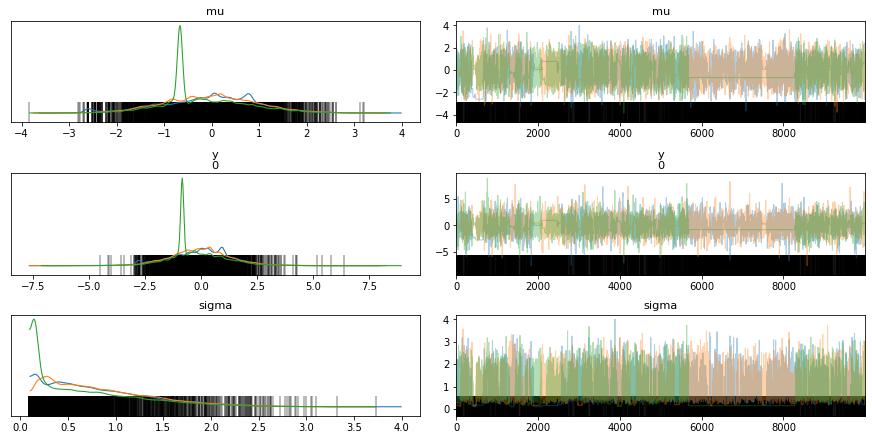

In [3]:
import arviz as az
print("------------ Centered model ------------")

# The bars indicate the location of the divergences in the sampling process
az.plot_trace(trace_cm, divergences='bottom')
az.summary(trace_cm)

------------ Non-centered model ------------


/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
mu    -0.001  1.005  -1.902    1.851      0.007    0.006   21283.0  14008.0   
yt[0]  0.008  1.009  -1.851    1.901      0.008    0.006   17563.0  14233.0   
sigma  0.812  0.604   0.000    1.903      0.005    0.003   16672.0  16672.0   
y[0]   0.014  1.429  -2.635    2.732      0.011    0.008   18363.0  16850.0   

       ess_bulk  ess_tail  r_hat  
mu      21272.0   17802.0    1.0  
yt[0]   17563.0   17653.0    1.0  
sigma   12311.0    9148.0    1.0  
y[0]    18828.0   17084.0    1.0

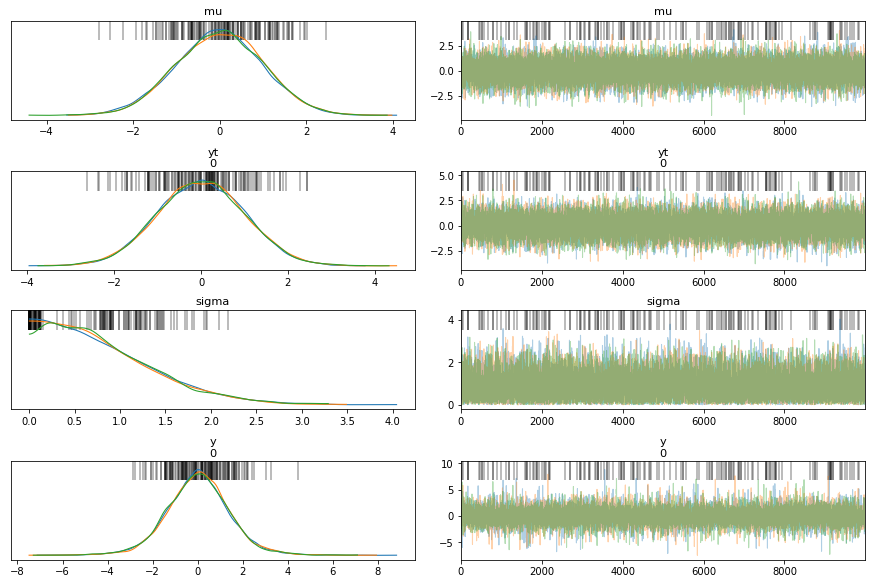

In [4]:
print("------------ Non-centered model ------------")

# The bars indicate the locations of divergences in the sampling process
az.plot_trace(trace_ncm, divergences='top')
az.summary(trace_ncm)

1. The posterior densities have more agreement for the non-centered model(ncm) compared to the centered model (cm), for the different chains.
2. There are more divergences for centered model compared to the non-centered model as can be seen from the vertical bars in the trace plot. 
3. In general, the non-centered model mixes better than the centered model - non-centered model looks fairly evenly mixed while centered model looks patchy in certain regions. 
4. It is possible to see flat lines in the trace for a centered model, a flat line indicates that the same sample value is being used because all new proposed samples are being rejected, in other words the sampler is sampling slowly and not getting to a different space in the manifold. The only fix here is to sample for longer periods of time, however we are assuming that we can get more unbiased samples if we let it run longer.


#### Forest Plot

We plot the densities of both the cm and the ncm models, notice the differences in effective sample sizes for the centered model (very low).

/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:>, <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

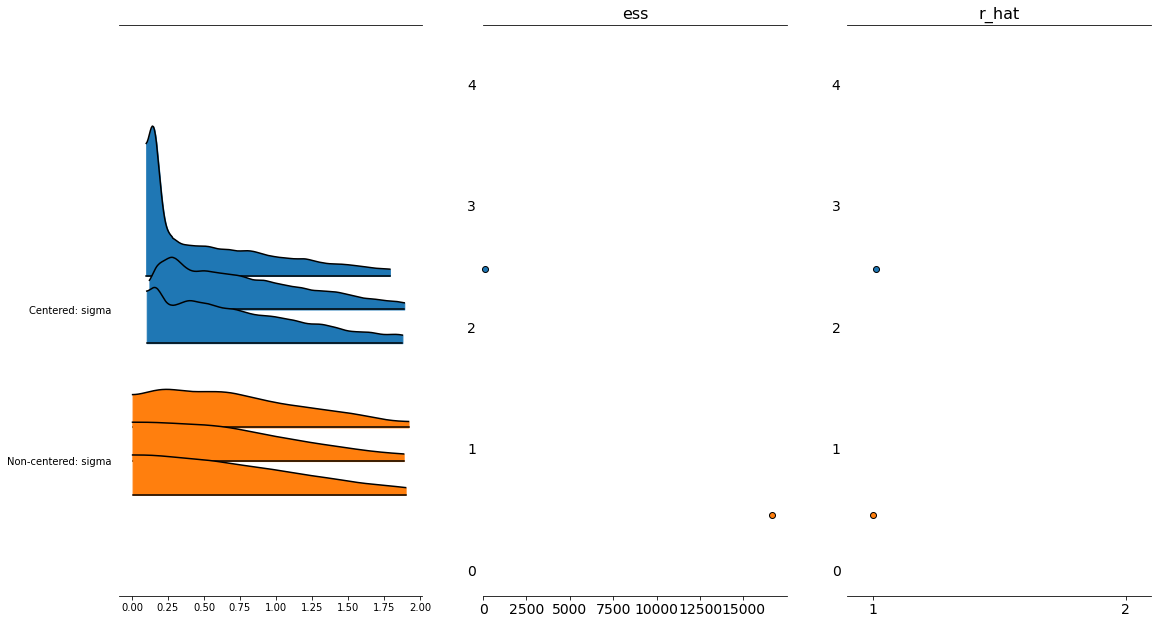

In [5]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)
az.plot_forest([trace_cm, trace_ncm], var_names=['sigma'], 
               kind = 'ridgeplot',
               model_names=['Centered','Non-centered'],
               combined=False, 
               ess=True, 
               r_hat=True, 
               ax=axs[0:3], 
               figsize=(20,20) )
#az.plot_forest(trace_ncm, var_names=['a'],
#               kind='ridgeplot',
#               combined=False, 
#               ess=True, 
#               r_hat=True, 
#               ax=axs[1,0:3])

#### Autocorrelation and effective sample sizes

Ideally, we would like to have zero correlation in the samples that are drawn. Correlated samples violate our condition of independence and can give us biased posterior estimates of our posterior distribution. 
Thinning or pruning refers to the process of dropping every nth sample from a chain. This is to minimize the number of correlated samples that might be drawn, especially if the proposal distribution is narrow. The autocorrelation plot computes the correlation of a sequence with itself but shifted by n; for each n on the x axis the corresponding value of autocorrelation is plotted on the y axis.  

`az.plot_autocorr(trace, var_names=["a", "b"])`

Techniques like Metropolis-Hastings are susceptible to having auto-correlated samples. We plot the autocorrelation here for the cm and the ncm models. The cm models have samples that have a high degree of autocorrelation while the ncm models does not.

/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Text(0.5, 1.0, 'Sigma - non-centered model')

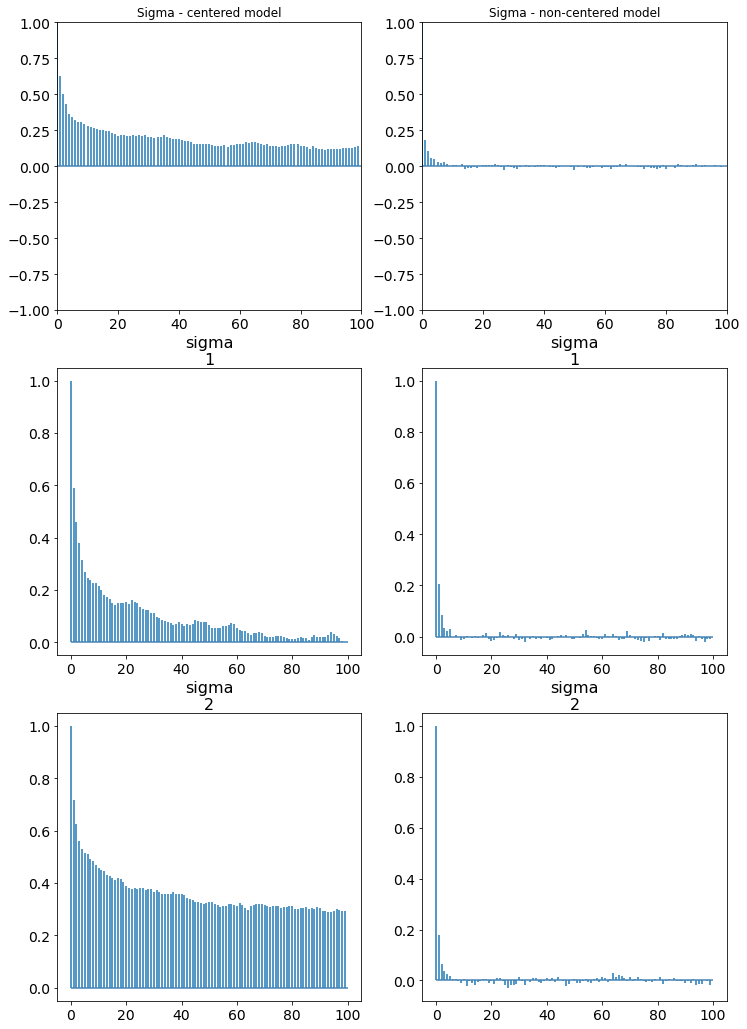

In [6]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(12, 18)
az.plot_autocorr(trace_cm, var_names=['sigma'], ax=axs[0:3,0])
az.plot_autocorr(trace_ncm, var_names=['sigma'], ax=axs[0:3,1])
axs[0][0].set_title('Sigma - centered model')
axs[0][1].set_title('Sigma - non-centered model')

Since a chain with autocorrelation has fewer samples that are independent, we can calculate the number of effective samples called the effective sample size. This is listed when a summary of the trace is printed out, however it can also be explicitly computed using

`az.effective_n(trace_s)`

PyMC3 will throw a warning if the number of effective samples is less than 200 (200 is heuristically determined to provide a good approximation for the mean of a distribution). Unless you want to sample from the tails of a distribution (rare events), 1000 to 2000 samples should provide a good approximation for a distribution.



#### Monte Carlo error 

The Monte Carlo error is a measure of the error of our sampler which stems from the fact that not all samples that we have drawn are independent. This error is defined by dividing a trace into 'n' blocks. We then compute the mean of these blocks and calculate the error as the standard deviation of these means over the square root of the number of blocks.

$mc_{error} = \sigma(\mu(block_i)) / \sqrt(n)$



#### Divergence

Divergences happen in regions of high curvature or high gradient in the manifold. When PyMC3 detects a divergence it abandons that chain, and as a result the samples that are reported to have been diverging are close to the space of high curvature but not necessarily right on it.

In some cases, PyMC3 can indicate falsely that some samples are divergences, this is due to the heuristics used to identify divergences. Concentration of samples in a region is an indication that these are not divergences. 

We visualize this for the cm and ncm models with pairplots of the variables. You can see how the cm models have difficulty sampling at the edge of the funnel shaped two-dimensional manifold formed by the pairplot.

In [7]:
# Get the divergences
print("Number of divergences in cm model, %d and %lf percent " % (trace_cm['diverging'].nonzero()[0].shape[0], trace_cm['diverging'].nonzero()[0].shape[0]/ len(trace_cm) * 100))
divergent = trace_cm['diverging']

print("Number of divergences in ncm model, %d and %lf percent " % (trace_ncm['diverging'].nonzero()[0].shape[0], trace_ncm['diverging'].nonzero()[0].shape[0]/ len(trace_ncm) * 100))
divergent = trace_cm['diverging']

Number of divergences in cm model, 7311 and 73.110000 percent 
Number of divergences in ncm model, 157 and 1.570000 percent 


#### Pairplot

Centered model


/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='sigma'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu', ylabel='y\n0'>,
        <AxesSubplot:xlabel='sigma'>]], dtype=object)

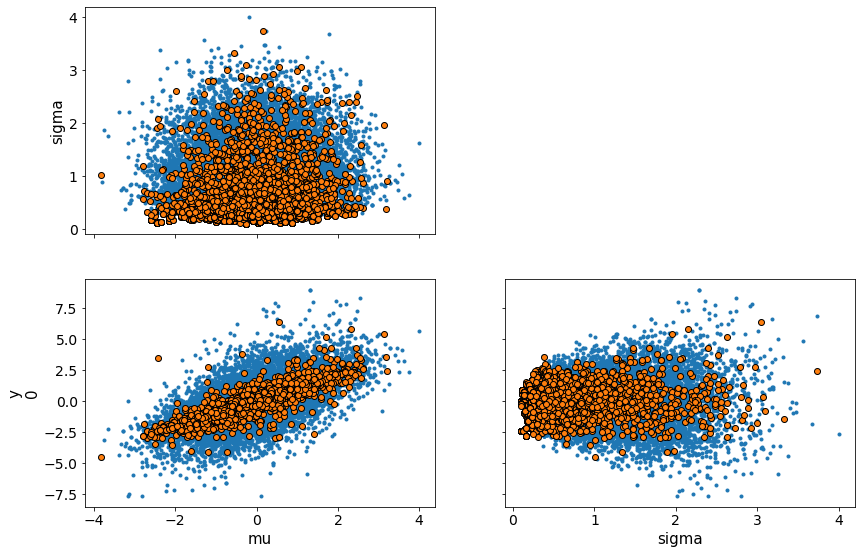

In [8]:
print("Centered model")
az.plot_pair(trace_cm, var_names = ['mu', 'sigma', 'y'], divergences=True)

Non-centered model


/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='sigma'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu', ylabel='y\n0'>,
        <AxesSubplot:xlabel='sigma'>]], dtype=object)

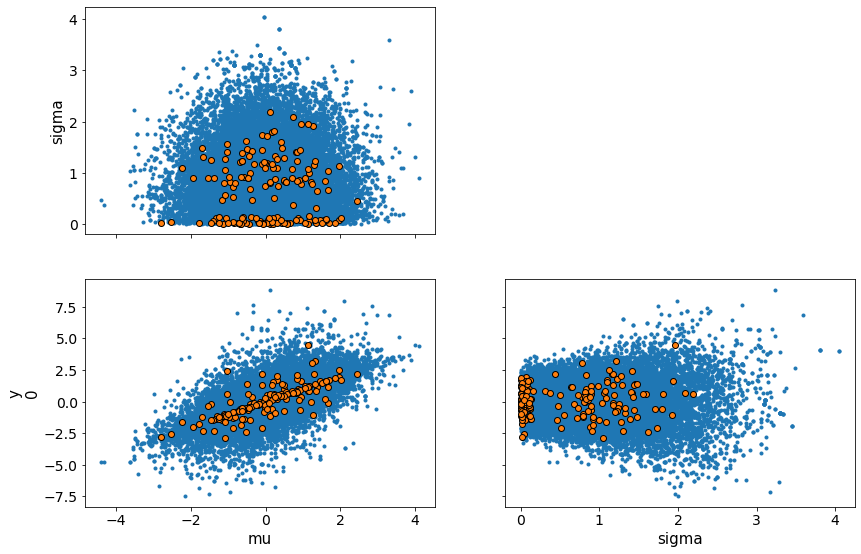

In [9]:
print("Non-centered model")
az.plot_pair(trace_ncm, var_names = ['mu', 'sigma', 'y'], divergences=True)

##### Parallel Coordinates

You can also have a parallel coordinates plot of the variables to look at the multidimensional data instead of pairplots. If we notice tight-knit lines around a region, that is an indication of difficulty sampling and hence divergences. This behavior can be observed in the centered model around 0 while the non-centered model has a sparser cluster of lines around 0. Sparser clusters can be an indication of false positives where divergences are reported. Apart from reformulating the problem, there are two ways to avoid the problem of divergences. 

1. Increase the tuning samples
2. Increase 'target_accept'

The parallel coordinates below show a much denser set of lines for the divergences for the centered model.

/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/srijith.rajamohan/opt/anaconda3/envs/pymc3nightly_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'NCM model'}>

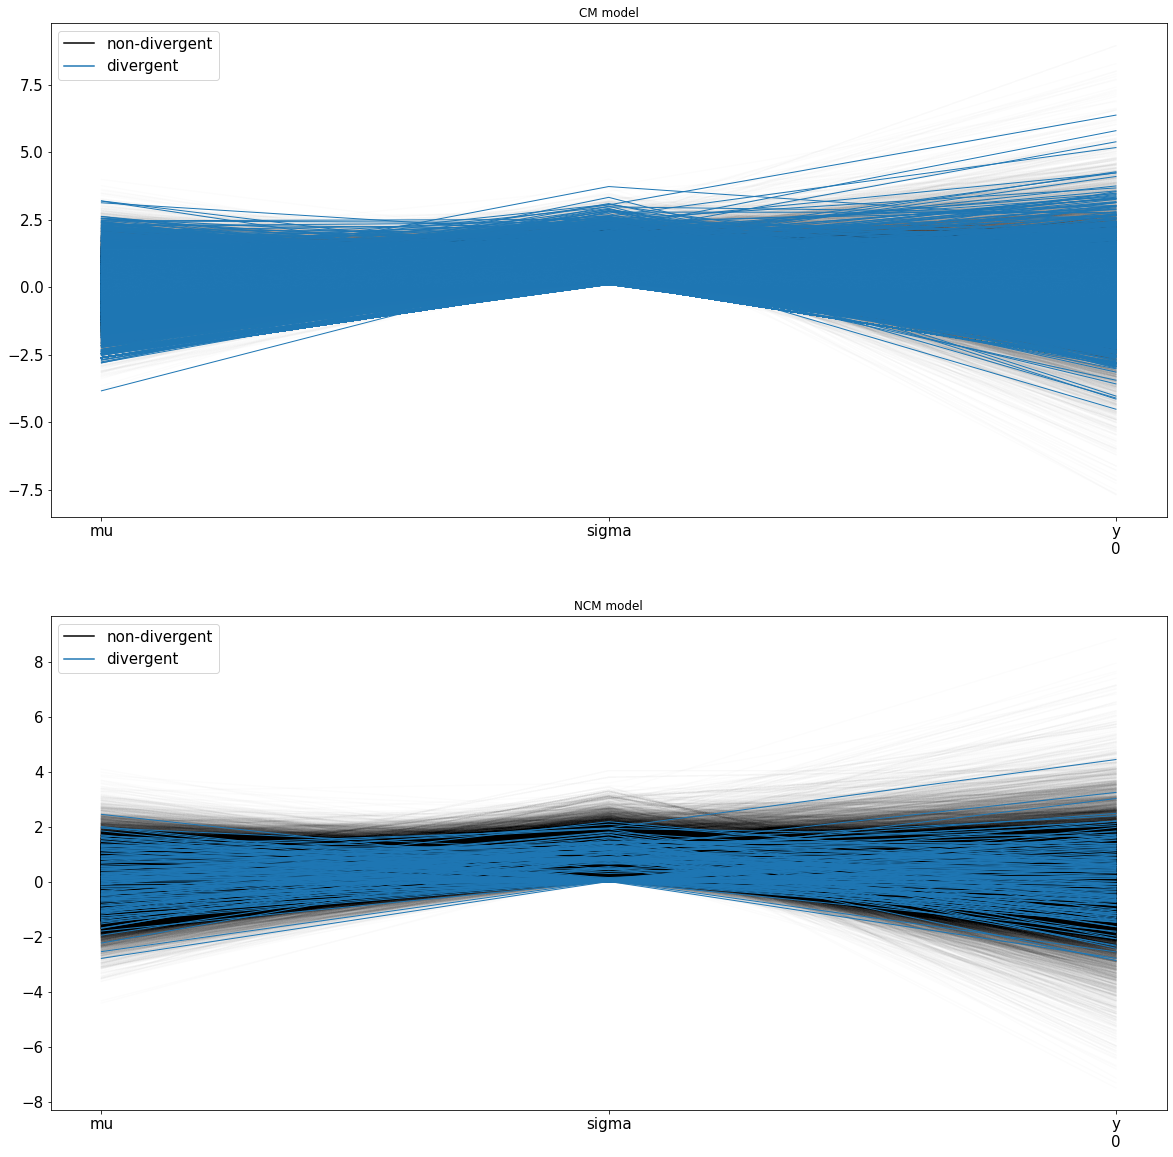

In [10]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(20,20)
axs[0].set_title('CM model')
axs[1].set_title('NCM model')
az.plot_parallel(trace_cm, var_names=['mu','sigma','y'], figsize=(20,20), shadend=0.01, colord='tab:blue', textsize=15, ax=axs[0])
az.plot_parallel(trace_ncm, var_names=['mu','sigma','y'], figsize=(20,20), shadend=0.01, colord='tab:blue', textsize=15,ax=axs[1])

#### A note on why we compute the log of the posterior

In short, this is done to avoid numerical overflow or underflow issues. When dealing with really large or small numbers, it is likely the limited precision of storage types (float, double etc.) can be an issue. In order to avoid this, the log of the probabilities are used instead in the calculations.

### Revisiting the Multiclass Classification Problem

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


'0.98'

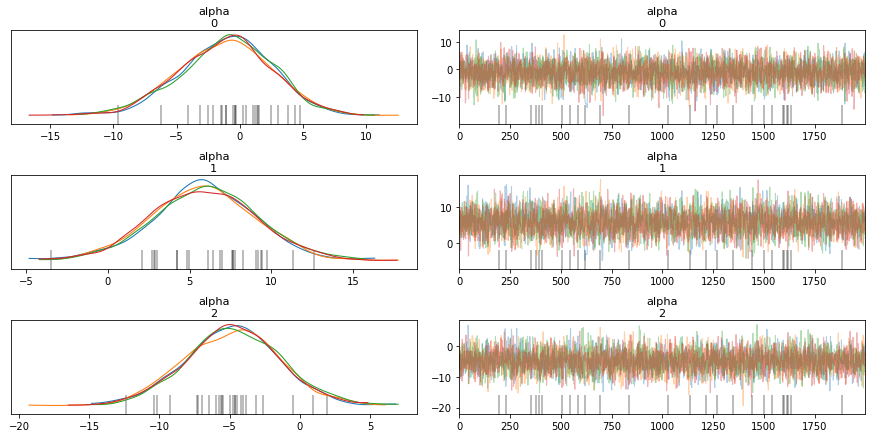

In [6]:
y_s = iris_data.target
x_n = iris_data.columns[:-1]
x_s = iris_data[x_n]
x_s = (x_s - x_s.mean()) / x_s.std()
x_s = x_s.values

import theano as tt
#tt.config.gcc.cxxflags = "-Wno-c++11-narrowing"

with pm.Model() as model_mclass:
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=3)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', alpha + pm.math.dot(x_s, beta))
    θ = tt.tensor.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]
az.plot_trace(trace_s, var_names=['alpha'])
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

#### Diagnostics

All diagnostics in PyMC3 are now in Arviz starting with version 3.9 of PyMC3. The 'summary' method is a good place to start.

In [9]:
az.summary(trace_s)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha[0]   -1.058  3.780  -8.325    5.799      0.063    0.048    3589.0   
alpha[1]    5.840  3.231  -0.192   11.925      0.059    0.042    3017.0   
alpha[2]   -4.778  3.442 -11.187    1.655      0.066    0.047    2733.0   
beta[0,0]  -2.610  4.117 -10.405    5.037      0.064    0.050    4142.0   
beta[0,1]   1.894  3.293  -4.201    8.252      0.062    0.044    2787.0   
...           ...    ...     ...      ...        ...      ...       ...   
μ[148,1]    3.126  6.832  -9.646   15.966      0.122    0.086    3160.0   
μ[148,2]   10.605  6.899  -2.340   23.381      0.119    0.086    3372.0   
μ[149,0]  -11.036  5.579 -21.938   -0.915      0.086    0.062    4185.0   
μ[149,1]    4.205  4.656  -4.255   13.274      0.087    0.062    2858.0   
μ[149,2]    6.805  4.697  -1.989   15.694      0.087    0.061    2920.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha[0]   3122.0    3628.0    4271.0    1.0  
alpha[1]   3017.0    3022.0    3836.0    1.0  
alpha[2]   2733.0    2736.0    3486.0    1.0  
beta[0,0]  3327.0    4165.0    3976.0    1.0  
beta[0,1]  2787.0    2792.0    3355.0    1.0  
...           ...       ...       ...    ...  
μ[148,1]   3160.0    3166.0    4028.0    1.0  
μ[148,2]   3239.0    3387.0    4014.0    1.0  
μ[149,0]   4065.0    4198.0    4767.0    1.0  
μ[149,1]   2858.0    2862.0    3806.0    1.0  
μ[149,2]   2920.0    2925.0    3757.0    1.0  

[465 rows x 11 columns]

#### Rhat

In [10]:
az.rhat(trace_s)

<xarray.Dataset>
Dimensions:      (alpha_dim_0: 3, beta_dim_0: 4, beta_dim_1: 3, μ_dim_0: 150, μ_dim_1: 3)
Coordinates:
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2
  * beta_dim_0   (beta_dim_0) int64 0 1 2 3
  * beta_dim_1   (beta_dim_1) int64 0 1 2
  * μ_dim_0      (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * μ_dim_1      (μ_dim_1) int64 0 1 2
Data variables:
    alpha        (alpha_dim_0) float64 1.0 1.001 1.001
    beta         (beta_dim_0, beta_dim_1) float64 1.001 1.001 ... 1.0 1.001
    μ            (μ_dim_0, μ_dim_1) float64 1.001 1.001 1.0 ... 1.001 1.0 1.0

#### Stat Names

Print out the available statistics for your model.

In [11]:
trace_s.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'perf_counter_diff',
 'perf_counter_start',
 'process_time_diff',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

In [12]:
import seaborn as sns
print("Length of trace_s",len(trace_s.energy), max(trace_s.energy))
print("Depth of the tree used to generate the sample  ",trace_s.depth)
# If tree size is too large, it is an indication of difficulty sampling, due to correlations, sharp posterior space
# or long-tailed posteriors. A solution is to reparameterize the model.
print("Tree size  ",trace_s.tree_size)
print("Energy at the point where the sample was generated ",trace_s.energy)
# This is difference in energy beween the start and the end of the trajectory, should ideally be zero
print("Energy error between start and end of the trajectory ",trace_s.energy_error)
# maximum difference in energy along the whole trajectory of sampling, this can help identify divergences
print("Energy error maximum over the entire trajectory ",trace_s.max_energy_error)
print("Step size ",trace_s.step_size)
print("Best step size determined from tuning ",trace_s.step_size_bar)

Length of trace_s 8000 85.27436221098932
Depth of the tree used to generate the sample   [5 5 5 ... 6 5 6]
Tree size   [31. 31. 31. ... 63. 31. 63.]
Energy at the point where the sample was generated  [67.60260509 71.9989758  67.11958372 ... 62.29556323 63.4178659
 68.47732931]
Energy error between start and end of the trajectory  [-0.01308503 -0.00519639  0.15062165 ... -0.00040919  0.36297431
  0.0268963 ]
Energy error maximum over the entire trajectory  [  0.59337975  12.23336243 210.17707617 ...   6.49041347   2.38167132
   2.75552062]
Step size  [0.13179172 0.13179172 0.13179172 ... 0.1181592  0.1181592  0.1181592 ]
Best step size determined from tuning  [0.11613223 0.11613223 0.11613223 ... 0.11001385 0.11001385 0.11001385]


#### Trace Energy

Ideally, you want the energy of your trace and the transition energy to be similar. If your transition energy is too narrow, it could imply that your sampler does not have enough energy to sample the entire posterior space and the sampled results may not appropriately represent the posterior well (biased estimate).

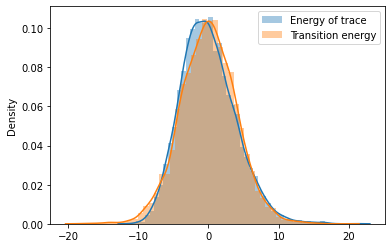

In [17]:
energy_diff = np.diff(trace_s.energy)
sns.distplot(trace_s.energy - trace_s.energy.mean(), label="Energy of trace")
sns.distplot(energy_diff, label="Transition energy")
plt.legend()

<AxesSubplot:>

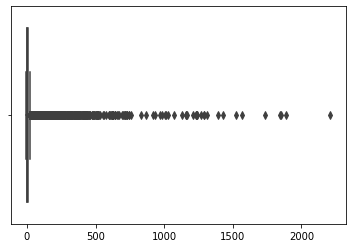

In [20]:
# Seaborn uses the interquartile range to draw the box plot whiskers given by Q1 - 1.5IQR, Q3 + 1.5IQR
# The boxplot helps to better visualize the density of outliers
sns.boxplot(trace_s.max_energy_error)

The energy and the energy transition should be as close as possible if the energy transition is smaller or narrower than the marginal energy, it implies that the sampler did not sample the space appropriately and that the results obtained are probably biased.

<AxesSubplot:>

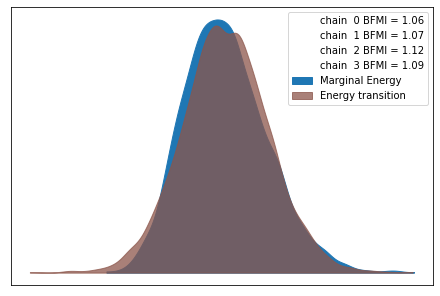

In [16]:
pm.energyplot(trace_s)

#### Step size

The variation of step size through the sampling process.

<AxesSubplot:>

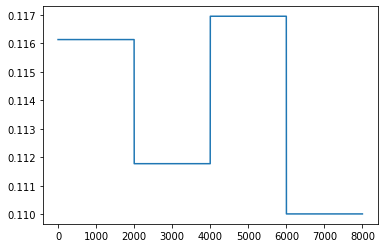

In [21]:
sns.lineplot(np.arange(0,len(trace_s.step_size_bar)), trace_s.step_size_bar)

#### Convergence with the Geweke Score

The Geweke score is a z-score that is computed at various segments in the time-series for an inferred parameter. 
A score of less than 2 (less than 2 standard deviations) indicates good convergence. It computes the z-score between each segment and the last 50%, by default, from the sampled chain. The function `pm.geweke` returns an array of (interval start location, z-score)

In [7]:
pm.geweke(trace_s['alpha'])

array([[ 0.00000000e+00, -1.64177407e-03],
       [ 2.10000000e+02, -1.93876484e-02],
       [ 4.21000000e+02, -5.96878074e-02],
       [ 6.31000000e+02, -3.75154517e-02],
       [ 8.42000000e+02, -3.54967016e-02],
       [ 1.05200000e+03, -1.33707673e-02],
       [ 1.26300000e+03,  7.23970572e-03],
       [ 1.47300000e+03,  2.58405319e-02],
       [ 1.68400000e+03,  2.68190262e-03],
       [ 1.89400000e+03, -3.28226146e-04],
       [ 2.10500000e+03, -2.66005904e-02],
       [ 2.31500000e+03, -1.86748532e-02],
       [ 2.52600000e+03, -2.44376140e-02],
       [ 2.73600000e+03, -2.21331281e-02],
       [ 2.94700000e+03, -2.43697434e-02],
       [ 3.15700000e+03, -1.20595485e-02],
       [ 3.36800000e+03, -2.49474340e-03],
       [ 3.57800000e+03, -6.57561572e-05],
       [ 3.78900000e+03,  1.63419595e-02],
       [ 3.99900000e+03,  4.32800662e-03]])

#### Divergences

In [19]:
# Get the divergences
print("Number of divergences %d and percent %lf " % (trace_s['diverging'].nonzero()[0].shape[0], trace_s['diverging'].nonzero()[0].shape[0]/ len(trace_s) * 100))
divergent = trace_s['diverging']
beta_divergent = trace_s['beta'][divergent]
print("Shape of beta_divergent - Sum of divergences from all chains x shape of variable ", beta_divergent.shape)

Number of divergences 45 and percent 2.250000 
Shape of beta_divergent - Sum of divergences from all chains x shape of variable  (45, 4, 3)


In [20]:
import pprint
print("Total number of warnings ",len(trace_s.report._warnings))
pprint.pprint(trace_s.report._warnings[0])

dir(trace_s.report._warnings[0])

print("---------- Message ----------")
pprint.pprint(trace_s.report._warnings[0].message)
print("---------- Kind of warning ----------")
pprint.pprint(trace_s.report._warnings[0].kind)
print("---------- Level ----------")
pprint.pprint(trace_s.report._warnings[0].level)
print("---------- Step ----------")
pprint.pprint(trace_s.report._warnings[0].step)
print("---------- Source ---------- ")
pprint.pprint(trace_s.report._warnings[0].divergence_point_source)
print("---------- Destination ---------- ")
pprint.pprint(trace_s.report._warnings[0].divergence_point_dest)

Total number of warnings  91
SamplerWarning(kind=<WarningType.DIVERGENCE: 1>, message='Energy change in leapfrog step is too large: 1125.7016827875798.', level='debug', step=619, exec_info=None, extra=None, divergence_point_source={'beta': array([[-10.47463223,   6.84447214,  -0.22581915],
       [ 13.94154109,  -4.31458424,  -3.7518639 ],
       [-15.6104532 ,   2.11284973,  14.94884339],
       [ -6.29133212,  12.27334961,   8.17802271]]), 'alpha': array([-3.63431888,  4.15729572, -1.41284765])}, divergence_point_dest={'beta': array([[-10.31152645,   2.56320011,   2.89205034],
       [ 16.82542185,  -3.55522448,  -6.07551638],
       [-17.03565014,  -2.34182098,  19.00123962],
       [ -7.01971749,   5.74299871,  15.79030048]]), 'alpha': array([-2.44701796, -0.58727453,  3.09177839])}, divergence_info=DivergenceInfo(message='Energy change in leapfrog step is too large: 1125.7016827875798.', exec_info=None, state=State(q=array([-10.47463223,   6.84447214,  -0.22581915,  13.94154109,
 

In [21]:
trace_s.report._warnings[0].divergence_info

DivergenceInfo(message='Energy change in leapfrog step is too large: 1125.7016827875798.', exec_info=None, state=State(q=array([-10.47463223,   6.84447214,  -0.22581915,  13.94154109,
        -4.31458424,  -3.7518639 , -15.6104532 ,   2.11284973,
        14.94884339,  -6.29133212,  12.27334961,   8.17802271,
        -3.63431888,   4.15729572,  -1.41284765]), p=array([-0.0468817 ,  1.45600196, -0.3760104 , -2.08606746, -0.63177533,
        1.85380117,  0.63825177,  1.00338427, -0.88341018,  0.34551366,
        2.51318959, -2.62090391, -0.69631122,  2.01992156, -1.63358436]), v=array([ -0.88955198,  12.34266958,  -3.13094119, -24.58988195,
        -6.57587893,  19.91280947,  12.7038853 ,  10.67192003,
        -8.95702275,   6.3913023 ,  25.96321708, -31.21513185,
        -9.84647872,  19.4300757 , -16.48217459]), q_grad=array([  0.42402054, -46.70601731,  46.43623594,  -0.55065619,
        -0.32719935,   0.64285183,   0.62641701, -42.15918653,
        41.47471993,   0.25250937, -46.86357

In [22]:
for elem in trace_s.report._warnings:
    print(elem.step)

619
792
1276
1544
1805
None
619
792
1276
1544
1805
1710
None
619
792
1276
1544
1805
1710
20
166
309
318
589
623
657
864
873
1102
1177
1188
1288
1377
1465
1528
1585
1609
1722
1726
1732
1843
1860
1915
1962
None
619
792
1276
1544
1805
1710
20
166
309
318
589
623
657
864
873
1102
1177
1188
1288
1377
1465
1528
1585
1609
1722
1726
1732
1843
1860
1915
1962
149
384
441
552
607
717
1045
1112
1118
1357
1672
1707
1713
1833
None


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


array([[<AxesSubplot:title={'center':'α\n0'}>,
        <AxesSubplot:title={'center':'α\n0'}>],
       [<AxesSubplot:title={'center':'α\n1'}>,
        <AxesSubplot:title={'center':'α\n1'}>]], dtype=object)

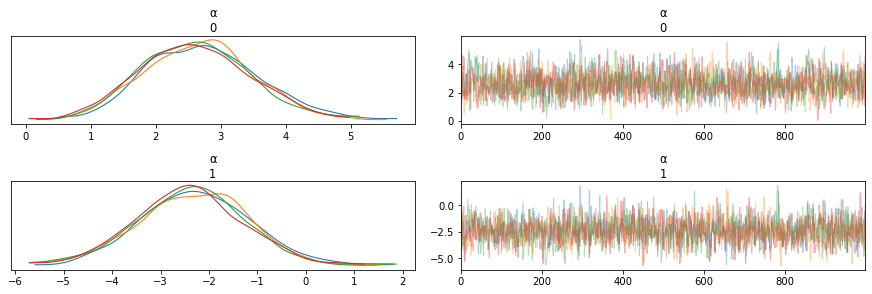

In [23]:
import theano as tt 
import arviz as az 

# If we run into the identifiability problem, we can solve for n-1 variables 
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.tensor.concatenate([[0] ,α])
    β_f = tt.tensor.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.tensor.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000)
    
az.plot_trace(trace_sf, var_names=['α'])

### Diagnosing MCMC using PyMC3

It is a good idea to inspect the quality of the solutions obtained. It is possible that one obtains suboptimal samples resulting in biased estimates, or the sampling is slow. There are two broad categories of tests, a visual inspection and a quantitative assessment. There are a few things that can be done if one suspects sampling issues.

1. More samples, it is possible that there aren't sufficient samples to come up with an appropriate posterior.
2. Use burn-in, this is removing a certain number of samples from the beginning while PyMC3 is figuring out the step size. This is set to 500 by default. With tuning it is not necessary to explicitly get rid of samples from the beginning.
3. Increase the number of samples used for tuning.
4. Increase the target_accept parameter as 

    `pm.sample(5000, chains=2, target_accept=0.95)`
    
    `pm.sample(5000, chains=2, nuts_kwargs=dict(target_accept=0.95))`
    
    Target_accept is the acceptance probability of the samples. This has the effect of varying the step size in the MCMC process so that we get the desired acceptance probability as indicated by the value of target_accept. It is a good idea to take smaller steps especially during Hamiltonian Monte Carlo so as to explore regions of high curvature better. Smaller step sizes lead to larger acceptance rates and larger step sizes lead to smaller acceptance rates. If the current acceptance rate is smaller than the target acceptance rate, the step size is reduced to increase the current acceptance rates.
    
5. Reparameterize the model so that the model, while remaining the same, is expressed differently so that is easier for the sampler to explore the distribution space.
6. Modify the data representation - mean centering and standardizing the data are two standard techniques that can be applied here. Note that (5) refers to model transformation while this is data transformation.

#### Debugging PyMC3

In [103]:
x = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)
    
    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sigma=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5, step)
    
trace['mu']

mu __str__ = 0.0
sd __str__ = 0.0


Only 5 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 5 draw iterations (4_000 + 20 draws total) took 8 seconds.


sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

### Arviz Data Representation

From the Arviz page, it states that, apart from NumPy arrays and Python dictionaries, there is support for a few data structures such as xarrays, InferenceData and NetCDF. While NumPy and dictionaries are great for in-memory computations, the other file formats are suitable for persisting computed data and models to disk. InferenceData is a high-level data structure that holds the data in a storage format such as NetCDF.

[Xarray documentation](http://xarray.pydata.org/en/stable/why-xarray.html)

[NetCDF documentation](http://unidata.github.io/netcdf4-python/netCDF4/index.html)

![Structure](https://arviz-devs.github.io/arviz/_images/InferenceDataStructure.png)


#### Load the school data

In [147]:
data = az.load_arviz_data("centered_eight")
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

In [155]:
data.posterior.get('mu')

<xarray.DataArray 'mu' (chain: 4, draw: 500)>
array([[-3.476986, -2.455871, -2.826254, ...,  3.392022,  8.46255 , -0.238516],
       [ 8.250863,  8.250863,  8.250863, ...,  2.527095,  0.276589,  5.655297],
       [10.51707 ,  9.887949,  8.500833, ..., -1.571177, -4.435385,  9.762948],
       [ 4.532296,  4.532296,  3.914097, ...,  4.597058,  5.898506,  0.161389]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [156]:
data = az.load_arviz_data("non_centered_eight")
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

#### Load the S&P500 returns data

In [297]:
sp500 = pd.read_csv(pm.get_data('SP500.csv'), index_col='Date')
sp500

Close    change
Date                             
2008-05-02  1413.900024  0.003230
2008-05-05  1407.489990 -0.004544
2008-05-06  1418.260010  0.007623
2008-05-07  1392.569946 -0.018280
2008-05-08  1397.680054  0.003663
...                 ...       ...
2019-11-08  3093.080078  0.002557
2019-11-11  3087.010010 -0.001964
2019-11-12  3091.840088  0.001563
2019-11-13  3094.040039  0.000711
2019-11-14  3096.629883  0.000837

[2906 rows x 2 columns]

### GRADED EVALUATION (36 min)

1. For Metropolis-Hastings algorithms, an acceptance rate of 23.4 was shown to be ideal

    a. True (C)
    
    b. False
    

2. A high acceptance rate (>90%) is an indication that the sampler is not exploring the space very well

    a. True (C)
    
    b. False
    
    
3. A low acceptance rate is an indication that 

    a. An incorrect proposal distribution is being used (C)
    
    b. The variance of the proposal distribution is too low
    
  
4. When using the NUTS algorithm, PyMC3 aims to get an acceptance rate of 

    a. 75%
    
    b. 85% (C)
    
    
5. If you have convergence issues, it is better to

    a. Try increasing the total number of samples drawn
    
    b. Try increasing the number of tuning samples (C)
    
    
6. A step size that is too large can result in 

    a. Large sample values
    
    b. Invalid sample values (C)
    
    
7. Large step sizes in Hamiltonian Monte Carlo can result in 

    a. Integration errors (C)
    
    b. Out-of-bounds errors
    
    
8. Mixing in MCMC refers to

    a. How well the sampling covers the entire distribution space (C)
    
    b. The similarity of the sample values
    
    
9. Rhat, used to measure mixing measures 

    a. the variance between the chains
    
    b. the ratio of the variance between the chains to the variance within the chains (C)
    
    
10. Rhat values below 1.1 indicate convergence while those above do not

    a. True (C)
    
    b. False
    
    
11. Thinning or pruning refers to dropping every n'th sample to avoid correlated samples

    a. True (C)
    
    b. False
    
    
12. Divergences happen in regions of high curvature or sharp gradients in the sampling manifold

    a. True (C)
    
    b. False